In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.date, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, self.signal_features.shape[1]) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        
        #股息
        import yfinance as yf
        self.Ticker = yf.Ticker("2330.TW")#抓取股票
        self.Dividends = self.Ticker.actions['Dividends']#抓取股息資料
        self.Dividends_Date = self.Dividends.index.astype('string')#將股息日期->String
        self.Dividends_Date = np.array(self.Dividends_Date)#將股息日期->np.array
        self.Dividends = np.array(self.Dividends) #抓取股息價錢
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-10).tolist()
        long_ticks = (np.array(long_ticks)-10).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")
        plt.savefig('2330_BBands_TotalProfit.jpg')
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [2]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        date = self.df.loc[:, 'index'].to_numpy() #prices：日期
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】
        
        
        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, date, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string

        
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #買入手續費 = (今天收盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #賣出手續費 = (明天開盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 明天開盤 * 稅率

                    Buy = current_price + Buy_trade_fee #買入成本 = 今天收盤 + 買入手續費
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax #賣出成本 = 明天開盤 - 賣出手續費 - 證交稅



                    price_diff = Sold - Buy #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）
                
                
                
                
                elif(action == Actions.Sell.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #買入手續費 = (明天開盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #賣出手續費 = (今天收盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 今天收盤 * 稅率

                    Buy = last_trade_price + Buy_trade_fee #買入成本 = 明天開盤 + 買入手續費
                    Sold = current_price - Sold_trade_fee - Transfer_tax #賣出成本 = 今天收盤 - 賣出手續費 - 證交稅    
     

                    price_diff = Sold - Buy #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

        
            step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = current_price + Buy_trade_fee#買入的成本
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax#賣出的成本


                    price_diff = Sold - Buy

                    long_profit_percentage = (Sold - Buy)/Buy 
                    self._total_profit += long_profit_percentage

                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = last_trade_price + Buy_trade_fee#買入的成本
                    Sold = current_price - Sold_trade_fee - Transfer_tax#賣出的成本


                    price_diff = Sold - Buy

                    short_profit_percentage = (Sold - Buy)/Buy 
                    self._total_profit += short_profit_percentage  
                       
                
            step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [3]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
if isinstance('2882.TW', str):
    # load it from yahoo_fin library
    df = si.get_data('2882.TW')
df = df.dropna()#丟棄空值
df = df.reset_index()
pd.set_option('display.float_format', lambda x: '%.3f' % x)#設定顯示小數點後3位數

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
volume = df['volume']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI

#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#成交量均線
volume10Day_mean=volume.ewm(span=10,adjust=False).mean() #10日移動平均成交量
volume10Day_mean = volume10Day_mean>volume #10日移動平均成交量 > 當日成交量【**技術指標**】
df_volume10day_mean=pd.DataFrame(volume10Day_mean) #變成DataFrame
labelencoder = LabelEncoder() #將True False 變成 1 0
df_volume10day_mean['volume'] = labelencoder.fit_transform(df_volume10day_mean['volume'])#將True False 變成 1 0
ct = ColumnTransformer([("volume", OneHotEncoder(), [0])], remainder = 'passthrough') #將1 0 變成 OneHotEncoder
df_volume10day_mean = ct.fit_transform(df_volume10day_mean)#將1 0 變成 OneHotEncoder
df_volume10day_mean = pd.DataFrame(df_volume10day_mean, columns = ['Volume_lower','Volume_greater'])
df_volume10day_mean['Volume_lower'] = pd.to_numeric(df_volume10day_mean['Volume_lower'], downcast='integer')
df_volume10day_mean['Volume_greater'] = pd.to_numeric(df_volume10day_mean['Volume_greater'], downcast='integer')







#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330 = pd.merge(df2330,df_volume10day_mean,left_index=True,right_index=True) #合併布林通道

df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [5]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df = df2330
df

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
0,2000-01-31,67.639,68.470,66.815,66.984,33.729,35636585.000,2882.TW,63.020,68.960,...,60.708,67.881,60.711,0.729,0.289,67.114,64.210,61.307,0,1
1,2000-02-01,67.639,69.955,67.148,69.955,35.224,89195350917.000,2882.TW,63.020,69.955,...,72.632,78.587,66.670,1.050,0.441,68.341,64.516,60.691,1,0
2,2000-02-09,72.591,72.591,70.118,71.106,35.804,79554019640.000,2882.TW,63.517,72.591,...,73.990,80.269,71.203,1.382,0.629,69.628,64.928,60.229,1,0
3,2000-02-10,71.106,73.416,70.609,70.779,35.639,95849891343.000,2882.TW,63.517,73.416,...,69.893,77.967,73.458,1.600,0.823,70.587,65.275,59.963,1,0
4,2000-02-11,70.943,71.270,69.294,69.458,34.974,67021400275.000,2882.TW,63.517,73.416,...,67.726,71.982,72.966,1.647,0.988,71.117,65.572,60.028,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5678,2023-02-23,43.250,43.550,43.200,43.300,43.300,18150375.000,2882.TW,42.250,44.500,...,55.435,58.972,62.194,0.527,0.543,44.315,43.130,41.945,0,1
5679,2023-02-24,43.300,43.600,43.200,43.450,43.450,22078754.000,2882.TW,42.800,44.500,...,56.383,52.060,58.816,0.497,0.534,44.275,43.202,42.130,1,0
5680,2023-03-01,43.350,43.550,42.600,42.750,42.750,33761315.000,2882.TW,42.600,44.500,...,51.456,37.338,51.656,0.413,0.509,44.273,43.205,42.137,1,0
5681,2023-03-02,43.200,43.200,42.600,43.000,43.000,11518689.000,2882.TW,42.600,44.500,...,53.271,31.910,45.074,0.362,0.480,44.257,43.227,42.198,0,1


# 查找DF的標籤

In [6]:
dfStartDate_Train = df[(df['index']=='2022-01-04')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

5404

In [7]:
dfEndDate_Train = df[(df['index']=='2022-12-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

5648

In [8]:
df[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
5404,2022-01-04,61.600,62.000,61.500,62.000,57.701,15550283.000,2882.TW,60.100,63.300,...,64.912,65.804,67.896,0.577,0.446,62.689,60.945,59.201,0,1
5405,2022-01-05,61.600,62.000,61.300,61.900,57.608,15061391.000,2882.TW,60.200,63.300,...,62.500,62.149,65.980,0.567,0.470,62.793,61.005,59.217,0,1
5406,2022-01-06,61.900,62.300,61.400,62.000,57.701,16157330.000,2882.TW,60.500,63.300,...,70.588,59.290,63.750,0.560,0.488,62.903,61.070,59.237,0,1
5407,2022-01-07,62.000,62.500,61.800,62.000,57.701,20744856.000,2882.TW,61.100,63.300,...,68.085,53.163,60.221,0.548,0.500,63.003,61.135,59.267,1,0
5408,2022-01-10,62.000,62.300,61.700,62.100,57.794,12088709.000,2882.TW,61.300,63.300,...,68.750,48.775,56.406,0.541,0.508,63.104,61.215,59.326,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5644,2022-12-26,41.150,41.200,40.900,41.000,41.000,9525232.000,2882.TW,39.850,41.500,...,54.545,49.686,32.690,-0.205,-0.120,43.773,41.389,39.006,0,1
5645,2022-12-27,41.000,41.300,41.000,41.150,41.150,8263666.000,2882.TW,39.850,41.500,...,50.980,59.387,41.589,-0.162,-0.128,43.463,41.274,39.086,0,1
5646,2022-12-28,40.850,41.100,40.600,40.650,40.650,15973148.000,2882.TW,39.850,41.500,...,44.068,55.753,46.310,-0.167,-0.136,43.066,41.129,39.193,0,1
5647,2022-12-29,40.500,40.600,40.050,40.100,40.100,17156465.000,2882.TW,39.850,41.500,...,37.681,42.219,44.947,-0.213,-0.152,42.620,40.961,39.302,0,1


In [9]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    date = df.loc[:, 'index'].to_numpy()[start:end]#抓取Date
    signal_features = df.loc[:, ['Volume_lower', 'Volume_greater']].to_numpy()[start:end]#抓取特徵資料
    return open, close, high, low, volnume, date, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, date,signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._date = date
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._date, self._signal_features

    
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [28]:
policy_kwargs = dict(net_arch=[64, 'lstm'])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
# model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs, learning_rate=0.00000001)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=5000000)

Wrapping the env in a DummyVecEnv.
----------------------------------
| explained_variance | -1.36e-05 |
| fps                | 13        |
| nupdates           | 1         |
| policy_entropy     | 0.693     |
| total_timesteps    | 5         |
| value_loss         | 2.03e+05  |
----------------------------------
----------------------------------
| explained_variance | -3.61e-05 |
| fps                | 319       |
| nupdates           | 100       |
| policy_entropy     | 0.693     |
| total_timesteps    | 500       |
| value_loss         | 6.56e+04  |
----------------------------------
----------------------------------
| explained_variance | -3.35e-05 |
| fps                | 361       |
| nupdates           | 200       |
| policy_entropy     | 0.693     |
| total_timesteps    | 1000      |
| value_loss         | 3.57e+05  |
----------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 377       |
| nupdates          

---------------------------------
| explained_variance | 1.53e-05 |
| fps                | 425      |
| nupdates           | 3000     |
| policy_entropy     | 0.00485  |
| total_timesteps    | 15000    |
| value_loss         | 5.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.19e-05 |
| fps                | 425      |
| nupdates           | 3100     |
| policy_entropy     | 0.0017   |
| total_timesteps    | 15500    |
| value_loss         | 9.18e+05 |
---------------------------------
---------------------------------
| explained_variance | 4.21e-05 |
| fps                | 426      |
| nupdates           | 3200     |
| policy_entropy     | 0.00187  |
| total_timesteps    | 16000    |
| value_loss         | 8.12e+05 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-06 |
| fps                | 426       |
| nupdates           | 3300      |
| policy_entropy     | 0.00209   |
| total_t

---------------------------------
| explained_variance | 1.51e-05 |
| fps                | 388      |
| nupdates           | 6000     |
| policy_entropy     | 0.000527 |
| total_timesteps    | 30000    |
| value_loss         | 1.41e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 388      |
| nupdates           | 6100     |
| policy_entropy     | 0.000539 |
| total_timesteps    | 30500    |
| value_loss         | 2.33e+06 |
---------------------------------
---------------------------------
| explained_variance | -1.5e-05 |
| fps                | 389      |
| nupdates           | 6200     |
| policy_entropy     | 0.000552 |
| total_timesteps    | 31000    |
| value_loss         | 9.13e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.09e-05 |
| fps                | 389      |
| nupdates           | 6300     |
| policy_entropy     | 0.000566 |
| total_timest

----------------------------------
| explained_variance | -2.57e-05 |
| fps                | 386       |
| nupdates           | 9000      |
| policy_entropy     | 0.000416  |
| total_timesteps    | 45000     |
| value_loss         | 3.99e+05  |
----------------------------------
----------------------------------
| explained_variance | -6.32e-05 |
| fps                | 386       |
| nupdates           | 9100      |
| policy_entropy     | 0.000422  |
| total_timesteps    | 45500     |
| value_loss         | 1.59e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.31e-05 |
| fps                | 386       |
| nupdates           | 9200      |
| policy_entropy     | 0.000429  |
| total_timesteps    | 46000     |
| value_loss         | 2.24e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.3e-05  |
| fps                | 386      |
| nupdates           | 9300     |
| policy_entropy     | 0

---------------------------------
| explained_variance | 4.46e-05 |
| fps                | 385      |
| nupdates           | 12000    |
| policy_entropy     | 0.000803 |
| total_timesteps    | 60000    |
| value_loss         | 1.77e+05 |
---------------------------------
---------------------------------
| explained_variance | 6.34e-05 |
| fps                | 384      |
| nupdates           | 12100    |
| policy_entropy     | 0.00083  |
| total_timesteps    | 60500    |
| value_loss         | 2.23e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.67e-05 |
| fps                | 384       |
| nupdates           | 12200     |
| policy_entropy     | 0.000858  |
| total_timesteps    | 61000     |
| value_loss         | 1.76e+05  |
----------------------------------
---------------------------------
| explained_variance | -0.681   |
| fps                | 384      |
| nupdates           | 12300    |
| policy_entropy     | 0.00239  |
| tota

---------------------------------
| explained_variance | 2.52e-05 |
| fps                | 383      |
| nupdates           | 15000    |
| policy_entropy     | 0.00159  |
| total_timesteps    | 75000    |
| value_loss         | 2.66e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.27e-05 |
| fps                | 382      |
| nupdates           | 15100    |
| policy_entropy     | 0.0017   |
| total_timesteps    | 75500    |
| value_loss         | 7.87e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.67e-05 |
| fps                | 381       |
| nupdates           | 15200     |
| policy_entropy     | 0.00183   |
| total_timesteps    | 76000     |
| value_loss         | 2.76e+05  |
----------------------------------
---------------------------------
| explained_variance | 6.2e-06  |
| fps                | 380      |
| nupdates           | 15300    |
| policy_entropy     | 0.00198  |
| tota

----------------------------------
| explained_variance | -1.01e-05 |
| fps                | 376       |
| nupdates           | 18000     |
| policy_entropy     | 0.000295  |
| total_timesteps    | 90000     |
| value_loss         | 1.44e+06  |
----------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 375       |
| nupdates           | 18100     |
| policy_entropy     | 0.000298  |
| total_timesteps    | 90500     |
| value_loss         | 1.23e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.78e-06 |
| fps                | 375      |
| nupdates           | 18200    |
| policy_entropy     | 0.000301 |
| total_timesteps    | 91000    |
| value_loss         | 5.66e+05 |
---------------------------------
----------------------------------
| explained_variance | -5.84e-06 |
| fps                | 374       |
| nupdates           | 18300     |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 373      |
| nupdates           | 21000    |
| policy_entropy     | 0.000147 |
| total_timesteps    | 105000   |
| value_loss         | 5.05e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.86e-06 |
| fps                | 373      |
| nupdates           | 21100    |
| policy_entropy     | 0.000148 |
| total_timesteps    | 105500   |
| value_loss         | 4.94e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 373       |
| nupdates           | 21200     |
| policy_entropy     | 0.000149  |
| total_timesteps    | 106000    |
| value_loss         | 1.08e+06  |
----------------------------------
---------------------------------
| explained_variance | 7.83e-05 |
| fps                | 373      |
| nupdates           | 21300    |
| policy_entropy     | 0.00015  |
| tota

---------------------------------
| explained_variance | 1.05e-05 |
| fps                | 374      |
| nupdates           | 24000    |
| policy_entropy     | 0.000175 |
| total_timesteps    | 120000   |
| value_loss         | 1.83e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 374       |
| nupdates           | 24100     |
| policy_entropy     | 0.000176  |
| total_timesteps    | 120500    |
| value_loss         | 6.97e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.48e-05 |
| fps                | 374       |
| nupdates           | 24200     |
| policy_entropy     | 0.000177  |
| total_timesteps    | 121000    |
| value_loss         | 1.82e+05  |
----------------------------------
---------------------------------
| explained_variance | 5.57e-05 |
| fps                | 374      |
| nupdates           | 24300    |
| policy_entropy     | 0.000178 

---------------------------------
| explained_variance | -2.03    |
| fps                | 375      |
| nupdates           | 27000    |
| policy_entropy     | 0.000663 |
| total_timesteps    | 135000   |
| value_loss         | 1.64e+06 |
---------------------------------
----------------------------------
| explained_variance | -4.41e-06 |
| fps                | 375       |
| nupdates           | 27100     |
| policy_entropy     | 0.000217  |
| total_timesteps    | 135500    |
| value_loss         | 9.2e+05   |
----------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 375      |
| nupdates           | 27200    |
| policy_entropy     | 0.000219 |
| total_timesteps    | 136000   |
| value_loss         | 8.21e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.13e-06 |
| fps                | 375      |
| nupdates           | 27300    |
| policy_entropy     | 0.00022  |
| tota

---------------------------------
| explained_variance | 2.15e-06 |
| fps                | 374      |
| nupdates           | 30000    |
| policy_entropy     | 0.000282 |
| total_timesteps    | 150000   |
| value_loss         | 1.34e+06 |
---------------------------------
----------------------------------
| explained_variance | -4.65e-06 |
| fps                | 374       |
| nupdates           | 30100     |
| policy_entropy     | 0.000284  |
| total_timesteps    | 150500    |
| value_loss         | 4.99e+05  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-06 |
| fps                | 374       |
| nupdates           | 30200     |
| policy_entropy     | 0.000288  |
| total_timesteps    | 151000    |
| value_loss         | 3.07e+06  |
----------------------------------
----------------------------------
| explained_variance | -4.41e-06 |
| fps                | 374       |
| nupdates           | 30300     |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 372       |
| nupdates           | 33000     |
| policy_entropy     | 0.000564  |
| total_timesteps    | 165000    |
| value_loss         | 5.75e+05  |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 372       |
| nupdates           | 33100     |
| policy_entropy     | 0.000576  |
| total_timesteps    | 165500    |
| value_loss         | 1.42e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 372      |
| nupdates           | 33200    |
| policy_entropy     | 0.00059  |
| total_timesteps    | 166000   |
| value_loss         | 8.72e+05 |
---------------------------------
----------------------------------
| explained_variance | -4.05e-06 |
| fps                | 371       |
| nupdates           | 33300     |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 5.07e-05 |
| fps                | 371      |
| nupdates           | 36000    |
| policy_entropy     | 0.00611  |
| total_timesteps    | 180000   |
| value_loss         | 1.74e+05 |
---------------------------------
----------------------------------
| explained_variance | -4.41e-06 |
| fps                | 371       |
| nupdates           | 36100     |
| policy_entropy     | 0.00181   |
| total_timesteps    | 180500    |
| value_loss         | 1.72e+05  |
----------------------------------
---------------------------------
| explained_variance | 3.81e-06 |
| fps                | 371      |
| nupdates           | 36200    |
| policy_entropy     | 0.00196  |
| total_timesteps    | 181000   |
| value_loss         | 2.77e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 371       |
| nupdates           | 36300     |
| policy_entropy     | 0.00213   |
|

---------------------------------
| explained_variance | 1.32e-05 |
| fps                | 373      |
| nupdates           | 39000    |
| policy_entropy     | 0.000189 |
| total_timesteps    | 195000   |
| value_loss         | 2.89e+03 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 373       |
| nupdates           | 39100     |
| policy_entropy     | 0.000191  |
| total_timesteps    | 195500    |
| value_loss         | 2.6e+04   |
----------------------------------
---------------------------------
| explained_variance | 2.68e-06 |
| fps                | 373      |
| nupdates           | 39200    |
| policy_entropy     | 0.000192 |
| total_timesteps    | 196000   |
| value_loss         | 1.82e+07 |
---------------------------------
----------------------------------
| explained_variance | -0.000224 |
| fps                | 373       |
| nupdates           | 39300     |
| policy_entropy     | 0.000193  |
|

---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 375      |
| nupdates           | 42000    |
| policy_entropy     | 8.85e-05 |
| total_timesteps    | 210000   |
| value_loss         | 6.99e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 375       |
| nupdates           | 42100     |
| policy_entropy     | 8.87e-05  |
| total_timesteps    | 210500    |
| value_loss         | 1.59e+06  |
----------------------------------
---------------------------------
| explained_variance | 2.5e-06  |
| fps                | 375      |
| nupdates           | 42200    |
| policy_entropy     | 8.9e-05  |
| total_timesteps    | 211000   |
| value_loss         | 3.79e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 375      |
| nupdates           | 42300    |
| policy_entropy     | 8.92e-05 |
| tota

----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 377       |
| nupdates           | 45000     |
| policy_entropy     | 9.7e-05   |
| total_timesteps    | 225000    |
| value_loss         | 1.78e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 377      |
| nupdates           | 45100    |
| policy_entropy     | 9.73e-05 |
| total_timesteps    | 225500   |
| value_loss         | 2.92e+05 |
---------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 378      |
| nupdates           | 45200    |
| policy_entropy     | 9.76e-05 |
| total_timesteps    | 226000   |
| value_loss         | 1.12e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 378       |
| nupdates           | 45300     |
| policy_entropy     | 9.79e-05  |
|

----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 379       |
| nupdates           | 48000     |
| policy_entropy     | 0.000107  |
| total_timesteps    | 240000    |
| value_loss         | 2.27e+05  |
----------------------------------
---------------------------------
| explained_variance | 5.01e-06 |
| fps                | 379      |
| nupdates           | 48100    |
| policy_entropy     | 0.000108 |
| total_timesteps    | 240500   |
| value_loss         | 4.74e+04 |
---------------------------------
----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 379       |
| nupdates           | 48200     |
| policy_entropy     | 0.000108  |
| total_timesteps    | 241000    |
| value_loss         | 2.51e+05  |
----------------------------------
----------------------------------
| explained_variance | -7.75e-06 |
| fps                | 379       |
| nupdates           | 48300     |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 380       |
| nupdates           | 51000     |
| policy_entropy     | 0.000119  |
| total_timesteps    | 255000    |
| value_loss         | 1.11e+06  |
----------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 380      |
| nupdates           | 51100    |
| policy_entropy     | 0.00012  |
| total_timesteps    | 255500   |
| value_loss         | 2.14e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.53e-06 |
| fps                | 380      |
| nupdates           | 51200    |
| policy_entropy     | 0.00012  |
| total_timesteps    | 256000   |
| value_loss         | 9.47e+04 |
---------------------------------
---------------------------------
| explained_variance | 8.58e-06 |
| fps                | 380      |
| nupdates           | 51300    |
| policy_entropy     | 0.000121 |
| tota

----------------------------------
| explained_variance | -0.000254 |
| fps                | 382       |
| nupdates           | 54000     |
| policy_entropy     | 0.000134  |
| total_timesteps    | 270000    |
| value_loss         | 7.01e+04  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 382       |
| nupdates           | 54100     |
| policy_entropy     | 0.000135  |
| total_timesteps    | 270500    |
| value_loss         | 1.31e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 382      |
| nupdates           | 54200    |
| policy_entropy     | 0.000135 |
| total_timesteps    | 271000   |
| value_loss         | 4.15e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.32e-06 |
| fps                | 382      |
| nupdates           | 54300    |
| policy_entropy     | 0.000136 

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 384       |
| nupdates           | 57000     |
| policy_entropy     | 0.000152  |
| total_timesteps    | 285000    |
| value_loss         | 6.17e+05  |
----------------------------------
---------------------------------
| explained_variance | 2.92e-06 |
| fps                | 384      |
| nupdates           | 57100    |
| policy_entropy     | 0.000153 |
| total_timesteps    | 285500   |
| value_loss         | 5.48e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 384       |
| nupdates           | 57200     |
| policy_entropy     | 0.000154  |
| total_timesteps    | 286000    |
| value_loss         | 1.16e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 384       |
| nupdates           | 57300     |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 387       |
| nupdates           | 60000     |
| policy_entropy     | 0.000176  |
| total_timesteps    | 300000    |
| value_loss         | 2.57e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 387       |
| nupdates           | 60100     |
| policy_entropy     | 0.000177  |
| total_timesteps    | 300500    |
| value_loss         | 6.16e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 388       |
| nupdates           | 60200     |
| policy_entropy     | 0.000178  |
| total_timesteps    | 301000    |
| value_loss         | 3.57e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 388      |
| nupdates           | 60300    |
| policy_entropy     | 0

---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 391      |
| nupdates           | 63000    |
| policy_entropy     | 7.93e-05 |
| total_timesteps    | 315000   |
| value_loss         | 9e+04    |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 391       |
| nupdates           | 63100     |
| policy_entropy     | 7.95e-05  |
| total_timesteps    | 315500    |
| value_loss         | 1.76e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 391      |
| nupdates           | 63200    |
| policy_entropy     | 7.97e-05 |
| total_timesteps    | 316000   |
| value_loss         | 2.36e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 391      |
| nupdates           | 63300    |
| policy_entropy     | 7.99e-05 |
| tota

---------------------------------
| explained_variance | 8.23e-06 |
| fps                | 393      |
| nupdates           | 66000    |
| policy_entropy     | 8.49e-05 |
| total_timesteps    | 330000   |
| value_loss         | 9.8e+04  |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 393       |
| nupdates           | 66100     |
| policy_entropy     | 8.51e-05  |
| total_timesteps    | 330500    |
| value_loss         | 6.32e+04  |
----------------------------------
---------------------------------
| explained_variance | -10.5    |
| fps                | 393      |
| nupdates           | 66200    |
| policy_entropy     | 0.000304 |
| total_timesteps    | 331000   |
| value_loss         | 2.16e+06 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 393       |
| nupdates           | 66300     |
| policy_entropy     | 8.56e-05  |
|

---------------------------------
| explained_variance | 2.62e-06 |
| fps                | 395      |
| nupdates           | 69000    |
| policy_entropy     | 9.14e-05 |
| total_timesteps    | 345000   |
| value_loss         | 6.11e+05 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 395       |
| nupdates           | 69100     |
| policy_entropy     | 9.16e-05  |
| total_timesteps    | 345500    |
| value_loss         | 1.79e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 395      |
| nupdates           | 69200    |
| policy_entropy     | 9.18e-05 |
| total_timesteps    | 346000   |
| value_loss         | 1.08e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 395       |
| nupdates           | 69300     |
| policy_entropy     | 9.2e-05   |
|

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 397       |
| nupdates           | 72000     |
| policy_entropy     | 5.76e-05  |
| total_timesteps    | 360000    |
| value_loss         | 9.44e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 397      |
| nupdates           | 72100    |
| policy_entropy     | 5.77e-05 |
| total_timesteps    | 360500   |
| value_loss         | 4.82e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 397      |
| nupdates           | 72200    |
| policy_entropy     | 5.78e-05 |
| total_timesteps    | 361000   |
| value_loss         | 6.31e+05 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 398       |
| nupdates           | 72300     |
| policy_entropy     | 5.78e-05  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 399      |
| nupdates           | 75000    |
| policy_entropy     | 6.04e-05 |
| total_timesteps    | 375000   |
| value_loss         | 2.95e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 400      |
| nupdates           | 75100    |
| policy_entropy     | 6.05e-05 |
| total_timesteps    | 375500   |
| value_loss         | 1.42e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.16e-05 |
| fps                | 400      |
| nupdates           | 75200    |
| policy_entropy     | 6.06e-05 |
| total_timesteps    | 376000   |
| value_loss         | 2.1e+05  |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 400       |
| nupdates           | 75300     |
| policy_entropy     | 6.06e-05  |
| total_t

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 402       |
| nupdates           | 78000     |
| policy_entropy     | 6.33e-05  |
| total_timesteps    | 390000    |
| value_loss         | 1.05e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 402      |
| nupdates           | 78100    |
| policy_entropy     | 6.34e-05 |
| total_timesteps    | 390500   |
| value_loss         | 7.17e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 402      |
| nupdates           | 78200    |
| policy_entropy     | 6.35e-05 |
| total_timesteps    | 391000   |
| value_loss         | 1.63e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 402      |
| nupdates           | 78300    |
| policy_entropy     | 6.36e-05 |
| tota

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 404       |
| nupdates           | 81000     |
| policy_entropy     | 6.65e-05  |
| total_timesteps    | 405000    |
| value_loss         | 1.24e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 404      |
| nupdates           | 81100    |
| policy_entropy     | 6.66e-05 |
| total_timesteps    | 405500   |
| value_loss         | 6.14e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 404      |
| nupdates           | 81200    |
| policy_entropy     | 6.67e-05 |
| total_timesteps    | 406000   |
| value_loss         | 8.8e+04  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 404      |
| nupdates           | 81300    |
| policy_entropy     | 6.7e-05  |
| tota

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 406       |
| nupdates           | 84000     |
| policy_entropy     | 7.02e-05  |
| total_timesteps    | 420000    |
| value_loss         | 6.98e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 406       |
| nupdates           | 84100     |
| policy_entropy     | 7.03e-05  |
| total_timesteps    | 420500    |
| value_loss         | 3.62e+06  |
----------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 406       |
| nupdates           | 84200     |
| policy_entropy     | 7.05e-05  |
| total_timesteps    | 421000    |
| value_loss         | 1.53e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 406       |
| nupdates           | 84300     |
| policy_entropy    

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 407       |
| nupdates           | 87000     |
| policy_entropy     | 7.39e-05  |
| total_timesteps    | 435000    |
| value_loss         | 1.1e+06   |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 407      |
| nupdates           | 87100    |
| policy_entropy     | 7.4e-05  |
| total_timesteps    | 435500   |
| value_loss         | 6.24e+05 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 407      |
| nupdates           | 87200    |
| policy_entropy     | 7.42e-05 |
| total_timesteps    | 436000   |
| value_loss         | 1.5e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 407      |
| nupdates           | 87300    |
| policy_entropy     | 7.44e-05 |
| tota

----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 408       |
| nupdates           | 90000     |
| policy_entropy     | 7.8e-05   |
| total_timesteps    | 450000    |
| value_loss         | 1.09e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 408       |
| nupdates           | 90100     |
| policy_entropy     | 7.81e-05  |
| total_timesteps    | 450500    |
| value_loss         | 1.96e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 408       |
| nupdates           | 90200     |
| policy_entropy     | 7.83e-05  |
| total_timesteps    | 451000    |
| value_loss         | 9.19e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 408      |
| nupdates           | 90300    |
| policy_entropy     | 7

----------------------------------
| explained_variance | -5.36e-06 |
| fps                | 409       |
| nupdates           | 93000     |
| policy_entropy     | 8.26e-05  |
| total_timesteps    | 465000    |
| value_loss         | 5.48e+03  |
----------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 409       |
| nupdates           | 93100     |
| policy_entropy     | 8.29e-05  |
| total_timesteps    | 465500    |
| value_loss         | 7.27e+07  |
----------------------------------
----------------------------------
| explained_variance | -0.000216 |
| fps                | 409       |
| nupdates           | 93200     |
| policy_entropy     | 8.3e-05   |
| total_timesteps    | 466000    |
| value_loss         | 3.8e+04   |
----------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 409       |
| nupdates           | 93300     |
| policy_entropy    

---------------------------------
| explained_variance | 0        |
| fps                | 410      |
| nupdates           | 96000    |
| policy_entropy     | 8.76e-05 |
| total_timesteps    | 480000   |
| value_loss         | 1.27e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 411      |
| nupdates           | 96100    |
| policy_entropy     | 8.78e-05 |
| total_timesteps    | 480500   |
| value_loss         | 2.53e+05 |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 411      |
| nupdates           | 96200    |
| policy_entropy     | 8.8e-05  |
| total_timesteps    | 481000   |
| value_loss         | 4.89e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 411      |
| nupdates           | 96300    |
| policy_entropy     | 8.81e-05 |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 412      |
| nupdates           | 99000    |
| policy_entropy     | 9.3e-05  |
| total_timesteps    | 495000   |
| value_loss         | 1.81e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 412      |
| nupdates           | 99100    |
| policy_entropy     | 9.32e-05 |
| total_timesteps    | 495500   |
| value_loss         | 8.7e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 412      |
| nupdates           | 99200    |
| policy_entropy     | 9.34e-05 |
| total_timesteps    | 496000   |
| value_loss         | 2.71e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 412      |
| nupdates           | 99300    |
| policy_entropy     | 9.35e-05 |
| total_timest

---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 413      |
| nupdates           | 102000   |
| policy_entropy     | 0.000148 |
| total_timesteps    | 510000   |
| value_loss         | 4.26e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 413       |
| nupdates           | 102100    |
| policy_entropy     | 0.000148  |
| total_timesteps    | 510500    |
| value_loss         | 1.44e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 413       |
| nupdates           | 102200    |
| policy_entropy     | 0.000149  |
| total_timesteps    | 511000    |
| value_loss         | 7.84e+04  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 413       |
| nupdates           | 102300    |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 413       |
| nupdates           | 105000    |
| policy_entropy     | 5.91e-05  |
| total_timesteps    | 525000    |
| value_loss         | 1.8e+06   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 413      |
| nupdates           | 105100   |
| policy_entropy     | 5.92e-05 |
| total_timesteps    | 525500   |
| value_loss         | 4.97e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 413      |
| nupdates           | 105200   |
| policy_entropy     | 5.92e-05 |
| total_timesteps    | 526000   |
| value_loss         | 5.85e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 413      |
| nupdates           | 105300   |
| policy_entropy     | 5.93e-05 |
| tota

---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 413      |
| nupdates           | 108000   |
| policy_entropy     | 6.15e-05 |
| total_timesteps    | 540000   |
| value_loss         | 1.05e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 414       |
| nupdates           | 108100    |
| policy_entropy     | 6.16e-05  |
| total_timesteps    | 540500    |
| value_loss         | 5.83e+05  |
----------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 414       |
| nupdates           | 108200    |
| policy_entropy     | 6.17e-05  |
| total_timesteps    | 541000    |
| value_loss         | 5.47e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 414       |
| nupdates           | 108300    |
| policy_entropy     | 6.18e

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 414      |
| nupdates           | 111000   |
| policy_entropy     | 6.41e-05 |
| total_timesteps    | 555000   |
| value_loss         | 4.11e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 414      |
| nupdates           | 111100   |
| policy_entropy     | 6.42e-05 |
| total_timesteps    | 555500   |
| value_loss         | 9.32e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 414      |
| nupdates           | 111200   |
| policy_entropy     | 6.43e-05 |
| total_timesteps    | 556000   |
| value_loss         | 8.25e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 414      |
| nupdates           | 111300   |
| policy_entropy     | 6.44e-05 |
| total_timest

----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 415       |
| nupdates           | 114000    |
| policy_entropy     | 6.66e-05  |
| total_timesteps    | 570000    |
| value_loss         | 4.58e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 415      |
| nupdates           | 114100   |
| policy_entropy     | 6.67e-05 |
| total_timesteps    | 570500   |
| value_loss         | 4.95e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 415      |
| nupdates           | 114200   |
| policy_entropy     | 6.69e-05 |
| total_timesteps    | 571000   |
| value_loss         | 2.21e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 415       |
| nupdates           | 114300    |
| policy_entropy     | 6.7e-05   |
|

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 416       |
| nupdates           | 117000    |
| policy_entropy     | 6.95e-05  |
| total_timesteps    | 585000    |
| value_loss         | 1.49e+06  |
----------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 416      |
| nupdates           | 117100   |
| policy_entropy     | 6.96e-05 |
| total_timesteps    | 585500   |
| value_loss         | 3.09e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 416       |
| nupdates           | 117200    |
| policy_entropy     | 6.97e-05  |
| total_timesteps    | 586000    |
| value_loss         | 1.38e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 416      |
| nupdates           | 117300   |
| policy_entropy     | 6.99e-05 

---------------------------------
| explained_variance | 1.11e-05 |
| fps                | 417      |
| nupdates           | 120000   |
| policy_entropy     | 7.25e-05 |
| total_timesteps    | 600000   |
| value_loss         | 2.27e+04 |
---------------------------------
---------------------------------
| explained_variance | -30.3    |
| fps                | 417      |
| nupdates           | 120100   |
| policy_entropy     | 0.000266 |
| total_timesteps    | 600500   |
| value_loss         | 2.8e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 417      |
| nupdates           | 120200   |
| policy_entropy     | 7.28e-05 |
| total_timesteps    | 601000   |
| value_loss         | 1.41e+06 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 417       |
| nupdates           | 120300    |
| policy_entropy     | 7.29e-05  |
| total_t

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 417       |
| nupdates           | 123000    |
| policy_entropy     | 7.58e-05  |
| total_timesteps    | 615000    |
| value_loss         | 1.47e+05  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 417       |
| nupdates           | 123100    |
| policy_entropy     | 7.59e-05  |
| total_timesteps    | 615500    |
| value_loss         | 8.8e+05   |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 417      |
| nupdates           | 123200   |
| policy_entropy     | 7.6e-05  |
| total_timesteps    | 616000   |
| value_loss         | 8.04e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 417      |
| nupdates           | 123300   |
| policy_entropy     | 7.61e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 418      |
| nupdates           | 126000   |
| policy_entropy     | 7.9e-05  |
| total_timesteps    | 630000   |
| value_loss         | 4.58e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 418      |
| nupdates           | 126100   |
| policy_entropy     | 7.91e-05 |
| total_timesteps    | 630500   |
| value_loss         | 7.02e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 418       |
| nupdates           | 126200    |
| policy_entropy     | 7.92e-05  |
| total_timesteps    | 631000    |
| value_loss         | 9.75e+05  |
----------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 418       |
| nupdates           | 126300    |
| policy_entropy     | 7.93e-05  |
|

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 419      |
| nupdates           | 129000   |
| policy_entropy     | 8.25e-05 |
| total_timesteps    | 645000   |
| value_loss         | 1.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 8.17e-06 |
| fps                | 419      |
| nupdates           | 129100   |
| policy_entropy     | 8.27e-05 |
| total_timesteps    | 645500   |
| value_loss         | 2.62e+05 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 419       |
| nupdates           | 129200    |
| policy_entropy     | 8.28e-05  |
| total_timesteps    | 646000    |
| value_loss         | 9.39e+04  |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 419      |
| nupdates           | 129300   |
| policy_entropy     | 8.3e-05  |
| tota

----------------------------------
| explained_variance | -9.66e-06 |
| fps                | 420       |
| nupdates           | 132000    |
| policy_entropy     | 8.64e-05  |
| total_timesteps    | 660000    |
| value_loss         | 3.04e+04  |
----------------------------------
---------------------------------
| explained_variance | 2.26e-06 |
| fps                | 420      |
| nupdates           | 132100   |
| policy_entropy     | 8.65e-05 |
| total_timesteps    | 660500   |
| value_loss         | 4.69e+04 |
---------------------------------
----------------------------------
| explained_variance | -8.94e-06 |
| fps                | 420       |
| nupdates           | 132200    |
| policy_entropy     | 8.67e-05  |
| total_timesteps    | 661000    |
| value_loss         | 8.91e+03  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-06 |
| fps                | 420       |
| nupdates           | 132300    |
| policy_entropy     | 8.68e

---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 420      |
| nupdates           | 135000   |
| policy_entropy     | 9.07e-05 |
| total_timesteps    | 675000   |
| value_loss         | 5.15e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 420      |
| nupdates           | 135100   |
| policy_entropy     | 9.09e-05 |
| total_timesteps    | 675500   |
| value_loss         | 1.22e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 420      |
| nupdates           | 135200   |
| policy_entropy     | 9.1e-05  |
| total_timesteps    | 676000   |
| value_loss         | 1.14e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 420      |
| nupdates           | 135300   |
| policy_entropy     | 9.13e-05 |
| total_timest

----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 421       |
| nupdates           | 138100    |
| policy_entropy     | 9.57e-05  |
| total_timesteps    | 690500    |
| value_loss         | 1.34e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 421      |
| nupdates           | 138200   |
| policy_entropy     | 9.58e-05 |
| total_timesteps    | 691000   |
| value_loss         | 1.41e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 421      |
| nupdates           | 138300   |
| policy_entropy     | 9.6e-05  |
| total_timesteps    | 691500   |
| value_loss         | 7.68e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 421       |
| nupdates           | 138400    |
| policy_entropy     | 9.61e-05  |
|

----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 421       |
| nupdates           | 141100    |
| policy_entropy     | 0.0001    |
| total_timesteps    | 705500    |
| value_loss         | 1e+05     |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 421      |
| nupdates           | 141200   |
| policy_entropy     | 0.0001   |
| total_timesteps    | 706000   |
| value_loss         | 5.09e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 421      |
| nupdates           | 141300   |
| policy_entropy     | 0.000101 |
| total_timesteps    | 706500   |
| value_loss         | 1.06e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 421       |
| nupdates           | 141400    |
| policy_entropy     | 0.000101  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 422      |
| nupdates           | 144100   |
| policy_entropy     | 0.000105 |
| total_timesteps    | 720500   |
| value_loss         | 7.69e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 422      |
| nupdates           | 144200   |
| policy_entropy     | 0.000106 |
| total_timesteps    | 721000   |
| value_loss         | 1.66e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 422      |
| nupdates           | 144300   |
| policy_entropy     | 0.000106 |
| total_timesteps    | 721500   |
| value_loss         | 3.94e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 422      |
| nupdates           | 144400   |
| policy_entropy     | 0.000106 |
| total_timest

---------------------------------
| explained_variance | -8.9e-05 |
| fps                | 422      |
| nupdates           | 147100   |
| policy_entropy     | 0.000111 |
| total_timesteps    | 735500   |
| value_loss         | 2.44e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 422      |
| nupdates           | 147200   |
| policy_entropy     | 0.000111 |
| total_timesteps    | 736000   |
| value_loss         | 9.46e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 422      |
| nupdates           | 147300   |
| policy_entropy     | 0.000112 |
| total_timesteps    | 736500   |
| value_loss         | 6.65e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 422      |
| nupdates           | 147400   |
| policy_entropy     | 0.000112 |
| total_timest

---------------------------------
| explained_variance | 1.55e-06 |
| fps                | 423      |
| nupdates           | 150100   |
| policy_entropy     | 0.000117 |
| total_timesteps    | 750500   |
| value_loss         | 3.94e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 423      |
| nupdates           | 150200   |
| policy_entropy     | 0.000118 |
| total_timesteps    | 751000   |
| value_loss         | 3.6e+05  |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 423       |
| nupdates           | 150300    |
| policy_entropy     | 0.000118  |
| total_timesteps    | 751500    |
| value_loss         | 8.43e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 423      |
| nupdates           | 150400   |
| policy_entropy     | 0.000118 |
| tota

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 423       |
| nupdates           | 153100    |
| policy_entropy     | 0.000124  |
| total_timesteps    | 765500    |
| value_loss         | 2.84e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 423      |
| nupdates           | 153200   |
| policy_entropy     | 0.000125 |
| total_timesteps    | 766000   |
| value_loss         | 3.97e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 423      |
| nupdates           | 153300   |
| policy_entropy     | 0.000125 |
| total_timesteps    | 766500   |
| value_loss         | 6.35e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 423      |
| nupdates           | 153400   |
| policy_entropy     | 0.000125 |
| tota

---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 424      |
| nupdates           | 156100   |
| policy_entropy     | 3.38e-05 |
| total_timesteps    | 780500   |
| value_loss         | 8e+04    |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 424       |
| nupdates           | 156200    |
| policy_entropy     | 3.38e-05  |
| total_timesteps    | 781000    |
| value_loss         | 1.38e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 424       |
| nupdates           | 156300    |
| policy_entropy     | 3.39e-05  |
| total_timesteps    | 781500    |
| value_loss         | 3.49e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 424       |
| nupdates           | 156400    |
| policy_entropy     | 3.39e

---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 424      |
| nupdates           | 159100   |
| policy_entropy     | 3.45e-05 |
| total_timesteps    | 795500   |
| value_loss         | 3.58e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 424      |
| nupdates           | 159200   |
| policy_entropy     | 3.45e-05 |
| total_timesteps    | 796000   |
| value_loss         | 1.23e+04 |
---------------------------------
---------------------------------
| explained_variance | -45.5    |
| fps                | 424      |
| nupdates           | 159300   |
| policy_entropy     | 0.000147 |
| total_timesteps    | 796500   |
| value_loss         | 3.13e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 424       |
| nupdates           | 159400    |
| policy_entropy     | 3.46e-05  |
| total_t

---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 425      |
| nupdates           | 162100   |
| policy_entropy     | 3.51e-05 |
| total_timesteps    | 810500   |
| value_loss         | 5.03e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 425       |
| nupdates           | 162200    |
| policy_entropy     | 3.51e-05  |
| total_timesteps    | 811000    |
| value_loss         | 1.4e+05   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 425      |
| nupdates           | 162300   |
| policy_entropy     | 3.51e-05 |
| total_timesteps    | 811500   |
| value_loss         | 7.98e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 425      |
| nupdates           | 162400   |
| policy_entropy     | 3.51e-05 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 425       |
| nupdates           | 165100    |
| policy_entropy     | 3.58e-05  |
| total_timesteps    | 825500    |
| value_loss         | 7.34e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 425      |
| nupdates           | 165200   |
| policy_entropy     | 3.58e-05 |
| total_timesteps    | 826000   |
| value_loss         | 4.54e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 425      |
| nupdates           | 165300   |
| policy_entropy     | 3.58e-05 |
| total_timesteps    | 826500   |
| value_loss         | 7.4e+05  |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 425       |
| nupdates           | 165400    |
| policy_entropy     | 3.59e-05  |
|

---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 426      |
| nupdates           | 168100   |
| policy_entropy     | 3.64e-05 |
| total_timesteps    | 840500   |
| value_loss         | 1.66e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 426      |
| nupdates           | 168200   |
| policy_entropy     | 3.64e-05 |
| total_timesteps    | 841000   |
| value_loss         | 1.76e+06 |
---------------------------------
---------------------------------
| explained_variance | 6.5e-06  |
| fps                | 426      |
| nupdates           | 168300   |
| policy_entropy     | 3.65e-05 |
| total_timesteps    | 841500   |
| value_loss         | 2.91e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 426       |
| nupdates           | 168400    |
| policy_entropy     | 3.65e-05  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 426      |
| nupdates           | 171100   |
| policy_entropy     | 3.72e-05 |
| total_timesteps    | 855500   |
| value_loss         | 1.76e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 426      |
| nupdates           | 171200   |
| policy_entropy     | 3.72e-05 |
| total_timesteps    | 856000   |
| value_loss         | 1.73e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 426      |
| nupdates           | 171300   |
| policy_entropy     | 3.72e-05 |
| total_timesteps    | 856500   |
| value_loss         | 6.71e+04 |
---------------------------------
----------------------------------
| explained_variance | -5.13e-06 |
| fps                | 426       |
| nupdates           | 171400    |
| policy_entropy     | 3.72e-05  |
| total_t

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 427       |
| nupdates           | 174100    |
| policy_entropy     | 3.79e-05  |
| total_timesteps    | 870500    |
| value_loss         | 1.56e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 427      |
| nupdates           | 174200   |
| policy_entropy     | 3.79e-05 |
| total_timesteps    | 871000   |
| value_loss         | 4.75e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.8e-06  |
| fps                | 427      |
| nupdates           | 174300   |
| policy_entropy     | 3.79e-05 |
| total_timesteps    | 871500   |
| value_loss         | 1.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 427      |
| nupdates           | 174400   |
| policy_entropy     | 3.79e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 427      |
| nupdates           | 177100   |
| policy_entropy     | 3.85e-05 |
| total_timesteps    | 885500   |
| value_loss         | 9.06e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 427      |
| nupdates           | 177200   |
| policy_entropy     | 3.87e-05 |
| total_timesteps    | 886000   |
| value_loss         | 4.12e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 427       |
| nupdates           | 177300    |
| policy_entropy     | 3.87e-05  |
| total_timesteps    | 886500    |
| value_loss         | 1.25e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 427      |
| nupdates           | 177400   |
| policy_entropy     | 3.87e-05 |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 427       |
| nupdates           | 180100    |
| policy_entropy     | 3.94e-05  |
| total_timesteps    | 900500    |
| value_loss         | 8.67e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 427      |
| nupdates           | 180200   |
| policy_entropy     | 3.94e-05 |
| total_timesteps    | 901000   |
| value_loss         | 4.46e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 427      |
| nupdates           | 180300   |
| policy_entropy     | 3.94e-05 |
| total_timesteps    | 901500   |
| value_loss         | 8.07e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 427      |
| nupdates           | 180400   |
| policy_entropy     | 3.95e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 428      |
| nupdates           | 183100   |
| policy_entropy     | 4.03e-05 |
| total_timesteps    | 915500   |
| value_loss         | 8.75e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 428      |
| nupdates           | 183200   |
| policy_entropy     | 4.03e-05 |
| total_timesteps    | 916000   |
| value_loss         | 1.59e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 428      |
| nupdates           | 183300   |
| policy_entropy     | 4.03e-05 |
| total_timesteps    | 916500   |
| value_loss         | 6.97e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 428      |
| nupdates           | 183400   |
| policy_entropy     | 4.03e-05 |
| total_timest

----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 428       |
| nupdates           | 186200    |
| policy_entropy     | 1.21e-05  |
| total_timesteps    | 931000    |
| value_loss         | 1.5e+08   |
----------------------------------
----------------------------------
| explained_variance | -1.87e-05 |
| fps                | 428       |
| nupdates           | 186300    |
| policy_entropy     | 1.21e-05  |
| total_timesteps    | 931500    |
| value_loss         | 2.23e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 428      |
| nupdates           | 186400   |
| policy_entropy     | 1.21e-05 |
| total_timesteps    | 932000   |
| value_loss         | 8.67e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 428      |
| nupdates           | 186500   |
| policy_entropy     | 1.21e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 189200   |
| policy_entropy     | 1.21e-05 |
| total_timesteps    | 946000   |
| value_loss         | 1.73e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 189300   |
| policy_entropy     | 1.21e-05 |
| total_timesteps    | 946500   |
| value_loss         | 3.47e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 189400   |
| policy_entropy     | 1.21e-05 |
| total_timesteps    | 947000   |
| value_loss         | 3.22e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 428       |
| nupdates           | 189500    |
| policy_entropy     | 1.21e-05  |
| total_t

---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 428      |
| nupdates           | 192200   |
| policy_entropy     | 1.22e-05 |
| total_timesteps    | 961000   |
| value_loss         | 6.75e+05 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 428      |
| nupdates           | 192300   |
| policy_entropy     | 1.22e-05 |
| total_timesteps    | 961500   |
| value_loss         | 2.92e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.81e-06 |
| fps                | 428       |
| nupdates           | 192400    |
| policy_entropy     | 1.22e-05  |
| total_timesteps    | 962000    |
| value_loss         | 3.5e+05   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 192500   |
| policy_entropy     | 1.22e-05 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 429      |
| nupdates           | 195200   |
| policy_entropy     | 1.23e-05 |
| total_timesteps    | 976000   |
| value_loss         | 7.4e+04  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 429      |
| nupdates           | 195300   |
| policy_entropy     | 1.23e-05 |
| total_timesteps    | 976500   |
| value_loss         | 8.58e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 195400   |
| policy_entropy     | 1.23e-05 |
| total_timesteps    | 977000   |
| value_loss         | 1.29e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 195500   |
| policy_entropy     | 1.23e-05 |
| total_timest

---------------------------------
| explained_variance | 2.09e-06 |
| fps                | 429      |
| nupdates           | 198200   |
| policy_entropy     | 1.24e-05 |
| total_timesteps    | 991000   |
| value_loss         | 3.51e+04 |
---------------------------------
---------------------------------
| explained_variance | 8.52e-06 |
| fps                | 429      |
| nupdates           | 198300   |
| policy_entropy     | 1.24e-05 |
| total_timesteps    | 991500   |
| value_loss         | 2.7e+04  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 429      |
| nupdates           | 198400   |
| policy_entropy     | 1.24e-05 |
| total_timesteps    | 992000   |
| value_loss         | 6.58e+03 |
---------------------------------
---------------------------------
| explained_variance | -64.2    |
| fps                | 429      |
| nupdates           | 198500   |
| policy_entropy     | 6.49e-05 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 429      |
| nupdates           | 201200   |
| policy_entropy     | 1.25e-05 |
| total_timesteps    | 1006000  |
| value_loss         | 7.63e+05 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 429      |
| nupdates           | 201300   |
| policy_entropy     | 1.25e-05 |
| total_timesteps    | 1006500  |
| value_loss         | 4.8e+05  |
---------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 429       |
| nupdates           | 201400    |
| policy_entropy     | 1.25e-05  |
| total_timesteps    | 1007000   |
| value_loss         | 1.37e+05  |
----------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 429       |
| nupdates           | 201500    |
| policy_entropy     | 1.25e-05  |
|

----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 429       |
| nupdates           | 204200    |
| policy_entropy     | 1.26e-05  |
| total_timesteps    | 1021000   |
| value_loss         | 7.47e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 429       |
| nupdates           | 204300    |
| policy_entropy     | 1.26e-05  |
| total_timesteps    | 1021500   |
| value_loss         | 6.81e+05  |
----------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 429      |
| nupdates           | 204400   |
| policy_entropy     | 1.26e-05 |
| total_timesteps    | 1022000  |
| value_loss         | 4.53e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 429       |
| nupdates           | 204500    |
| policy_entropy     | 1.26e

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 429      |
| nupdates           | 207200   |
| policy_entropy     | 1.26e-05 |
| total_timesteps    | 1036000  |
| value_loss         | 8.63e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 207300   |
| policy_entropy     | 1.26e-05 |
| total_timesteps    | 1036500  |
| value_loss         | 1.35e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 207400   |
| policy_entropy     | 1.26e-05 |
| total_timesteps    | 1037000  |
| value_loss         | 1.87e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-06 |
| fps                | 429      |
| nupdates           | 207500   |
| policy_entropy     | 1.26e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 210200   |
| policy_entropy     | 1.27e-05 |
| total_timesteps    | 1051000  |
| value_loss         | 4.02e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 210300   |
| policy_entropy     | 1.27e-05 |
| total_timesteps    | 1051500  |
| value_loss         | 2.05e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 210400   |
| policy_entropy     | 1.27e-05 |
| total_timesteps    | 1052000  |
| value_loss         | 8.19e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 210500   |
| policy_entropy     | 1.27e-05 |
| total_timest

---------------------------------
| explained_variance | -72.6    |
| fps                | 429      |
| nupdates           | 213200   |
| policy_entropy     | 6.68e-05 |
| total_timesteps    | 1066000  |
| value_loss         | 3.58e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 213300   |
| policy_entropy     | 1.28e-05 |
| total_timesteps    | 1066500  |
| value_loss         | 1.66e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 213400   |
| policy_entropy     | 1.28e-05 |
| total_timesteps    | 1067000  |
| value_loss         | 4.38e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 213500   |
| policy_entropy     | 1.28e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 216200   |
| policy_entropy     | 1.29e-05 |
| total_timesteps    | 1081000  |
| value_loss         | 6.98e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 429       |
| nupdates           | 216300    |
| policy_entropy     | 1.29e-05  |
| total_timesteps    | 1081500   |
| value_loss         | 9.8e+05   |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 429       |
| nupdates           | 216400    |
| policy_entropy     | 1.29e-05  |
| total_timesteps    | 1082000   |
| value_loss         | 4.29e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 216500   |
| policy_entropy     | 1.29e-05 

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 430      |
| nupdates           | 219200   |
| policy_entropy     | 1.3e-05  |
| total_timesteps    | 1096000  |
| value_loss         | 7.95e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 430       |
| nupdates           | 219300    |
| policy_entropy     | 1.3e-05   |
| total_timesteps    | 1096500   |
| value_loss         | 7.96e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 430      |
| nupdates           | 219400   |
| policy_entropy     | 1.3e-05  |
| total_timesteps    | 1097000  |
| value_loss         | 3.94e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 430       |
| nupdates           | 219500    |
| policy_entropy     | 1.3e-05   |
|

---------------------------------
| explained_variance | 5.3e-06  |
| fps                | 430      |
| nupdates           | 222200   |
| policy_entropy     | 1.31e-05 |
| total_timesteps    | 1111000  |
| value_loss         | 3.36e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 430       |
| nupdates           | 222300    |
| policy_entropy     | 1.31e-05  |
| total_timesteps    | 1111500   |
| value_loss         | 8.73e+04  |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 430       |
| nupdates           | 222400    |
| policy_entropy     | 1.31e-05  |
| total_timesteps    | 1112000   |
| value_loss         | 1.53e+05  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 430      |
| nupdates           | 222500   |
| policy_entropy     | 1.31e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 430      |
| nupdates           | 225200   |
| policy_entropy     | 1.32e-05 |
| total_timesteps    | 1126000  |
| value_loss         | 9.97e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 430       |
| nupdates           | 225300    |
| policy_entropy     | 1.32e-05  |
| total_timesteps    | 1126500   |
| value_loss         | 3.1e+04   |
----------------------------------
----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 430       |
| nupdates           | 225400    |
| policy_entropy     | 1.32e-05  |
| total_timesteps    | 1127000   |
| value_loss         | 1.83e+08  |
----------------------------------
---------------------------------
| explained_variance | 5.07e-05 |
| fps                | 430      |
| nupdates           | 225500   |
| policy_entropy     | 1.32e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 430      |
| nupdates           | 228200   |
| policy_entropy     | 1.33e-05 |
| total_timesteps    | 1141000  |
| value_loss         | 1.77e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 430      |
| nupdates           | 228300   |
| policy_entropy     | 1.33e-05 |
| total_timesteps    | 1141500  |
| value_loss         | 9.35e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 430       |
| nupdates           | 228400    |
| policy_entropy     | 1.33e-05  |
| total_timesteps    | 1142000   |
| value_loss         | 1.51e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 430      |
| nupdates           | 228500   |
| policy_entropy     | 1.33e-05 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 431       |
| nupdates           | 231200    |
| policy_entropy     | 1.35e-05  |
| total_timesteps    | 1156000   |
| value_loss         | 1.14e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 431      |
| nupdates           | 231300   |
| policy_entropy     | 1.35e-05 |
| total_timesteps    | 1156500  |
| value_loss         | 9.15e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 431      |
| nupdates           | 231400   |
| policy_entropy     | 1.35e-05 |
| total_timesteps    | 1157000  |
| value_loss         | 6.14e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 431      |
| nupdates           | 231500   |
| policy_entropy     | 1.35e-05 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 431      |
| nupdates           | 234200   |
| policy_entropy     | 1.36e-05 |
| total_timesteps    | 1171000  |
| value_loss         | 6.05e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 431      |
| nupdates           | 234300   |
| policy_entropy     | 1.36e-05 |
| total_timesteps    | 1171500  |
| value_loss         | 8.03e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 431      |
| nupdates           | 234400   |
| policy_entropy     | 1.36e-05 |
| total_timesteps    | 1172000  |
| value_loss         | 5.61e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 431       |
| nupdates           | 234500    |
| policy_entropy     | 1.36e-05  |
| total_t

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 431      |
| nupdates           | 237200   |
| policy_entropy     | 1.37e-05 |
| total_timesteps    | 1186000  |
| value_loss         | 6.09e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 431       |
| nupdates           | 237300    |
| policy_entropy     | 1.37e-05  |
| total_timesteps    | 1186500   |
| value_loss         | 1.43e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 431      |
| nupdates           | 237400   |
| policy_entropy     | 1.37e-05 |
| total_timesteps    | 1187000  |
| value_loss         | 3.59e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 431      |
| nupdates           | 237500   |
| policy_entropy     | 1.37e-05 |
| tota

---------------------------------
| explained_variance | 7.46e-05 |
| fps                | 430      |
| nupdates           | 240200   |
| policy_entropy     | 1.38e-05 |
| total_timesteps    | 1201000  |
| value_loss         | 2.48e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 430       |
| nupdates           | 240300    |
| policy_entropy     | 1.38e-05  |
| total_timesteps    | 1201500   |
| value_loss         | 7.71e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 430      |
| nupdates           | 240400   |
| policy_entropy     | 1.38e-05 |
| total_timesteps    | 1202000  |
| value_loss         | 8.31e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 430      |
| nupdates           | 240500   |
| policy_entropy     | 1.38e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 243200   |
| policy_entropy     | 1.38e-05 |
| total_timesteps    | 1216000  |
| value_loss         | 2.92e+05 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 429      |
| nupdates           | 243300   |
| policy_entropy     | 1.38e-05 |
| total_timesteps    | 1216500  |
| value_loss         | 2.78e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 429       |
| nupdates           | 243400    |
| policy_entropy     | 1.39e-05  |
| total_timesteps    | 1217000   |
| value_loss         | 6.89e+05  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 429       |
| nupdates           | 243500    |
| policy_entropy     | 1.39e-05  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 246200   |
| policy_entropy     | 1.39e-05 |
| total_timesteps    | 1231000  |
| value_loss         | 3.03e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 246300   |
| policy_entropy     | 1.39e-05 |
| total_timesteps    | 1231500  |
| value_loss         | 2.95e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 429      |
| nupdates           | 246400   |
| policy_entropy     | 1.39e-05 |
| total_timesteps    | 1232000  |
| value_loss         | 1.04e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 429      |
| nupdates           | 246500   |
| policy_entropy     | 1.4e-05  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 428       |
| nupdates           | 249200    |
| policy_entropy     | 1.4e-05   |
| total_timesteps    | 1246000   |
| value_loss         | 9.78e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 428      |
| nupdates           | 249300   |
| policy_entropy     | 1.4e-05  |
| total_timesteps    | 1246500  |
| value_loss         | 1.18e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 428      |
| nupdates           | 249400   |
| policy_entropy     | 1.4e-05  |
| total_timesteps    | 1247000  |
| value_loss         | 4.39e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 428      |
| nupdates           | 249500   |
| policy_entropy     | 1.4e-05  |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 428       |
| nupdates           | 252200    |
| policy_entropy     | 1.41e-05  |
| total_timesteps    | 1261000   |
| value_loss         | 2.11e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 428      |
| nupdates           | 252300   |
| policy_entropy     | 1.41e-05 |
| total_timesteps    | 1261500  |
| value_loss         | 4.45e+03 |
---------------------------------
---------------------------------
| explained_variance | -94.2    |
| fps                | 428      |
| nupdates           | 252400   |
| policy_entropy     | 7.21e-05 |
| total_timesteps    | 1262000  |
| value_loss         | 3.88e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 428      |
| nupdates           | 252500   |
| policy_entropy     | 1.41e-05 |
| tota

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 427      |
| nupdates           | 255200   |
| policy_entropy     | 1.42e-05 |
| total_timesteps    | 1276000  |
| value_loss         | 4.58e+05 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 427       |
| nupdates           | 255300    |
| policy_entropy     | 1.42e-05  |
| total_timesteps    | 1276500   |
| value_loss         | 1.38e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 427      |
| nupdates           | 255400   |
| policy_entropy     | 1.42e-05 |
| total_timesteps    | 1277000  |
| value_loss         | 6.42e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 426      |
| nupdates           | 255500   |
| policy_entropy     | 1.42e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 424      |
| nupdates           | 258200   |
| policy_entropy     | 1.43e-05 |
| total_timesteps    | 1291000  |
| value_loss         | 6.23e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 424      |
| nupdates           | 258300   |
| policy_entropy     | 1.43e-05 |
| total_timesteps    | 1291500  |
| value_loss         | 4.58e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 424      |
| nupdates           | 258400   |
| policy_entropy     | 1.43e-05 |
| total_timesteps    | 1292000  |
| value_loss         | 8.3e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 424      |
| nupdates           | 258500   |
| policy_entropy     | 1.44e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 421      |
| nupdates           | 261200   |
| policy_entropy     | 1.44e-05 |
| total_timesteps    | 1306000  |
| value_loss         | 1.04e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 421      |
| nupdates           | 261300   |
| policy_entropy     | 1.44e-05 |
| total_timesteps    | 1306500  |
| value_loss         | 2.01e+06 |
---------------------------------
---------------------------------
| explained_variance | 7.57e-06 |
| fps                | 420      |
| nupdates           | 261400   |
| policy_entropy     | 1.45e-05 |
| total_timesteps    | 1307000  |
| value_loss         | 3.65e+05 |
---------------------------------
----------------------------------
| explained_variance | -5.25e-06 |
| fps                | 420       |
| nupdates           | 261500    |
| policy_entropy     | 1.45e-05  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 418      |
| nupdates           | 264200   |
| policy_entropy     | 1.45e-05 |
| total_timesteps    | 1321000  |
| value_loss         | 2.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 418      |
| nupdates           | 264300   |
| policy_entropy     | 1.46e-05 |
| total_timesteps    | 1321500  |
| value_loss         | 2.13e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 418      |
| nupdates           | 264400   |
| policy_entropy     | 1.46e-05 |
| total_timesteps    | 1322000  |
| value_loss         | 1.21e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 418      |
| nupdates           | 264500   |
| policy_entropy     | 1.46e-05 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 415      |
| nupdates           | 267300   |
| policy_entropy     | 1.47e-05 |
| total_timesteps    | 1336500  |
| value_loss         | 4.02e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 415       |
| nupdates           | 267400    |
| policy_entropy     | 1.47e-05  |
| total_timesteps    | 1337000   |
| value_loss         | 2e+05     |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 415      |
| nupdates           | 267500   |
| policy_entropy     | 1.47e-05 |
| total_timesteps    | 1337500  |
| value_loss         | 8.74e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 415      |
| nupdates           | 267600   |
| policy_entropy     | 1.47e-05 |
| tota

----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 412       |
| nupdates           | 270300    |
| policy_entropy     | 1.48e-05  |
| total_timesteps    | 1351500   |
| value_loss         | 4.48e+06  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 412       |
| nupdates           | 270400    |
| policy_entropy     | 1.48e-05  |
| total_timesteps    | 1352000   |
| value_loss         | 1.07e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 412      |
| nupdates           | 270500   |
| policy_entropy     | 1.48e-05 |
| total_timesteps    | 1352500  |
| value_loss         | 7.92e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 412      |
| nupdates           | 270600   |
| policy_entropy     | 1.48e-05 

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 410       |
| nupdates           | 273300    |
| policy_entropy     | 1.49e-05  |
| total_timesteps    | 1366500   |
| value_loss         | 3.41e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 410      |
| nupdates           | 273400   |
| policy_entropy     | 1.49e-05 |
| total_timesteps    | 1367000  |
| value_loss         | 5.16e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 410      |
| nupdates           | 273500   |
| policy_entropy     | 1.49e-05 |
| total_timesteps    | 1367500  |
| value_loss         | 9.41e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 410      |
| nupdates           | 273600   |
| policy_entropy     | 1.49e-05 |
| tota

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 407      |
| nupdates           | 276300   |
| policy_entropy     | 1.51e-05 |
| total_timesteps    | 1381500  |
| value_loss         | 1.51e+05 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 407      |
| nupdates           | 276400   |
| policy_entropy     | 1.51e-05 |
| total_timesteps    | 1382000  |
| value_loss         | 5.62e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 407      |
| nupdates           | 276500   |
| policy_entropy     | 1.51e-05 |
| total_timesteps    | 1382500  |
| value_loss         | 1.36e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 407      |
| nupdates           | 276600   |
| policy_entropy     | 1.51e-05 |
| total_timest

---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 404      |
| nupdates           | 279300   |
| policy_entropy     | 1.52e-05 |
| total_timesteps    | 1396500  |
| value_loss         | 2.21e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.000124 |
| fps                | 404      |
| nupdates           | 279400   |
| policy_entropy     | 1.52e-05 |
| total_timesteps    | 1397000  |
| value_loss         | 2.89e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 404       |
| nupdates           | 279500    |
| policy_entropy     | 1.52e-05  |
| total_timesteps    | 1397500   |
| value_loss         | 7.19e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 404      |
| nupdates           | 279600   |
| policy_entropy     | 1.52e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 402      |
| nupdates           | 282300   |
| policy_entropy     | 1.53e-05 |
| total_timesteps    | 1411500  |
| value_loss         | 1.33e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 401       |
| nupdates           | 282400    |
| policy_entropy     | 1.53e-05  |
| total_timesteps    | 1412000   |
| value_loss         | 2.64e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 401       |
| nupdates           | 282500    |
| policy_entropy     | 1.53e-05  |
| total_timesteps    | 1412500   |
| value_loss         | 2.56e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 401      |
| nupdates           | 282600   |
| policy_entropy     | 1.53e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 399      |
| nupdates           | 285300   |
| policy_entropy     | 1.54e-05 |
| total_timesteps    | 1426500  |
| value_loss         | 5.55e+05 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 399       |
| nupdates           | 285400    |
| policy_entropy     | 1.54e-05  |
| total_timesteps    | 1427000   |
| value_loss         | 3.09e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 399       |
| nupdates           | 285500    |
| policy_entropy     | 1.54e-05  |
| total_timesteps    | 1427500   |
| value_loss         | 2.67e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 399       |
| nupdates           | 285600    |
| policy_entropy     | 1.54e

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 397       |
| nupdates           | 288300    |
| policy_entropy     | 1.55e-05  |
| total_timesteps    | 1441500   |
| value_loss         | 4.1e+04   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 397      |
| nupdates           | 288400   |
| policy_entropy     | 1.55e-05 |
| total_timesteps    | 1442000  |
| value_loss         | 1.07e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 397       |
| nupdates           | 288500    |
| policy_entropy     | 1.55e-05  |
| total_timesteps    | 1442500   |
| value_loss         | 1.12e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 397      |
| nupdates           | 288600   |
| policy_entropy     | 1.55e-05 

---------------------------------
| explained_variance | 2.44e-06 |
| fps                | 395      |
| nupdates           | 291300   |
| policy_entropy     | 1.56e-05 |
| total_timesteps    | 1456500  |
| value_loss         | 4e+04    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 395      |
| nupdates           | 291400   |
| policy_entropy     | 1.56e-05 |
| total_timesteps    | 1457000  |
| value_loss         | 2.01e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 394      |
| nupdates           | 291500   |
| policy_entropy     | 1.56e-05 |
| total_timesteps    | 1457500  |
| value_loss         | 5.49e+03 |
---------------------------------
---------------------------------
| explained_variance | -114     |
| fps                | 394      |
| nupdates           | 291600   |
| policy_entropy     | 7.79e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 393      |
| nupdates           | 294300   |
| policy_entropy     | 1.57e-05 |
| total_timesteps    | 1471500  |
| value_loss         | 9.04e+05 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 392      |
| nupdates           | 294400   |
| policy_entropy     | 1.57e-05 |
| total_timesteps    | 1472000  |
| value_loss         | 4.48e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 392      |
| nupdates           | 294500   |
| policy_entropy     | 1.57e-05 |
| total_timesteps    | 1472500  |
| value_loss         | 1.41e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 392      |
| nupdates           | 294600   |
| policy_entropy     | 1.57e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 391      |
| nupdates           | 297300   |
| policy_entropy     | 1.58e-05 |
| total_timesteps    | 1486500  |
| value_loss         | 6.32e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 391       |
| nupdates           | 297400    |
| policy_entropy     | 1.58e-05  |
| total_timesteps    | 1487000   |
| value_loss         | 5.94e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 390      |
| nupdates           | 297500   |
| policy_entropy     | 1.58e-05 |
| total_timesteps    | 1487500  |
| value_loss         | 4.62e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 390      |
| nupdates           | 297600   |
| policy_entropy     | 1.58e-05 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 389      |
| nupdates           | 300300   |
| policy_entropy     | 1.59e-05 |
| total_timesteps    | 1501500  |
| value_loss         | 1.25e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 389      |
| nupdates           | 300400   |
| policy_entropy     | 1.59e-05 |
| total_timesteps    | 1502000  |
| value_loss         | 8.95e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 388      |
| nupdates           | 300500   |
| policy_entropy     | 1.59e-05 |
| total_timesteps    | 1502500  |
| value_loss         | 2.08e+06 |
---------------------------------
---------------------------------
| explained_variance | 6.38e-06 |
| fps                | 388      |
| nupdates           | 300600   |
| policy_entropy     | 1.59e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 387      |
| nupdates           | 303300   |
| policy_entropy     | 1.6e-05  |
| total_timesteps    | 1516500  |
| value_loss         | 4.8e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 387      |
| nupdates           | 303400   |
| policy_entropy     | 1.61e-05 |
| total_timesteps    | 1517000  |
| value_loss         | 2.65e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 387      |
| nupdates           | 303500   |
| policy_entropy     | 1.61e-05 |
| total_timesteps    | 1517500  |
| value_loss         | 846      |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 386       |
| nupdates           | 303600    |
| policy_entropy     | 1.61e-05  |
| total_t

---------------------------------
| explained_variance | -120     |
| fps                | 385      |
| nupdates           | 306300   |
| policy_entropy     | 8.02e-05 |
| total_timesteps    | 1531500  |
| value_loss         | 4.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 385      |
| nupdates           | 306400   |
| policy_entropy     | 1.62e-05 |
| total_timesteps    | 1532000  |
| value_loss         | 1.85e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 385      |
| nupdates           | 306500   |
| policy_entropy     | 1.62e-05 |
| total_timesteps    | 1532500  |
| value_loss         | 3.85e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 385      |
| nupdates           | 306600   |
| policy_entropy     | 1.62e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 383      |
| nupdates           | 309400   |
| policy_entropy     | 1.63e-05 |
| total_timesteps    | 1547000  |
| value_loss         | 1.11e+06 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 383       |
| nupdates           | 309500    |
| policy_entropy     | 1.63e-05  |
| total_timesteps    | 1547500   |
| value_loss         | 4.58e+06  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 383      |
| nupdates           | 309600   |
| policy_entropy     | 1.63e-05 |
| total_timesteps    | 1548000  |
| value_loss         | 1.03e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 383      |
| nupdates           | 309700   |
| policy_entropy     | 1.63e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 381      |
| nupdates           | 312500   |
| policy_entropy     | 1.09e-05 |
| total_timesteps    | 1562500  |
| value_loss         | 3.18e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 381      |
| nupdates           | 312600   |
| policy_entropy     | 1.09e-05 |
| total_timesteps    | 1563000  |
| value_loss         | 4.67e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 381      |
| nupdates           | 312700   |
| policy_entropy     | 1.09e-05 |
| total_timesteps    | 1563500  |
| value_loss         | 1.05e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 381      |
| nupdates           | 312800   |
| policy_entropy     | 1.09e-05 |
| total_timest

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 380       |
| nupdates           | 315500    |
| policy_entropy     | 1.1e-05   |
| total_timesteps    | 1577500   |
| value_loss         | 1.51e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 380      |
| nupdates           | 315600   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 1578000  |
| value_loss         | 5.31e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 380      |
| nupdates           | 315700   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 1578500  |
| value_loss         | 1.31e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 380      |
| nupdates           | 315800   |
| policy_entropy     | 1.1e-05  |
| tota

---------------------------------
| explained_variance | 0.000152 |
| fps                | 377      |
| nupdates           | 318600   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 1593000  |
| value_loss         | 3.26e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 377      |
| nupdates           | 318700   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 1593500  |
| value_loss         | 6.85e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 377      |
| nupdates           | 318800   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 1594000  |
| value_loss         | 9.26e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 377      |
| nupdates           | 318900   |
| policy_entropy     | 1.1e-05  |
| total_timest

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 375      |
| nupdates           | 321700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 1608500  |
| value_loss         | 2.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 375      |
| nupdates           | 321800   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 1609000  |
| value_loss         | 6.16e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 375      |
| nupdates           | 321900   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 1609500  |
| value_loss         | 5.83e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 375       |
| nupdates           | 322000    |
| policy_entropy     | 1.11e-05  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 372      |
| nupdates           | 324700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 1623500  |
| value_loss         | 2.5e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 372      |
| nupdates           | 324800   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 1624000  |
| value_loss         | 1.32e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 372      |
| nupdates           | 324900   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 1624500  |
| value_loss         | 8.41e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 372      |
| nupdates           | 325000   |
| policy_entropy     | 1.11e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 327700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 1638500  |
| value_loss         | 1.08e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 327800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 1639000  |
| value_loss         | 4.91e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 327900   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 1639500  |
| value_loss         | 2.73e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 370       |
| nupdates           | 328000    |
| policy_entropy     | 1.12e-05  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 330700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 1653500  |
| value_loss         | 6.94e+03 |
---------------------------------
---------------------------------
| explained_variance | -127     |
| fps                | 368      |
| nupdates           | 330800   |
| policy_entropy     | 6.02e-05 |
| total_timesteps    | 1654000  |
| value_loss         | 4.28e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 330900   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 1654500  |
| value_loss         | 1.88e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 368      |
| nupdates           | 331000   |
| policy_entropy     | 1.12e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 333800   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 1669000  |
| value_loss         | 5.75e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 333900   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 1669500  |
| value_loss         | 1.13e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 334000   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 1670000  |
| value_loss         | 4.61e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 367      |
| nupdates           | 334100   |
| policy_entropy     | 1.13e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 336800   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 1684000  |
| value_loss         | 8.78e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 336900   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 1684500  |
| value_loss         | 6.76e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 365      |
| nupdates           | 337000   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 1685000  |
| value_loss         | 3.09e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 337100   |
| policy_entropy     | 1.13e-05 |
| total_timest

---------------------------------
| explained_variance | 6.14e-06 |
| fps                | 363      |
| nupdates           | 339800   |
| policy_entropy     | 1.14e-05 |
| total_timesteps    | 1699000  |
| value_loss         | 4.03e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 363       |
| nupdates           | 339900    |
| policy_entropy     | 1.14e-05  |
| total_timesteps    | 1699500   |
| value_loss         | 9.57e+04  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 363       |
| nupdates           | 340000    |
| policy_entropy     | 1.14e-05  |
| total_timesteps    | 1700000   |
| value_loss         | 1.52e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 340100   |
| policy_entropy     | 1.14e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 342800   |
| policy_entropy     | 1.14e-05 |
| total_timesteps    | 1714000  |
| value_loss         | 1.5e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 342900   |
| policy_entropy     | 1.14e-05 |
| total_timesteps    | 1714500  |
| value_loss         | 5.94e+04 |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 362      |
| nupdates           | 343000   |
| policy_entropy     | 1.14e-05 |
| total_timesteps    | 1715000  |
| value_loss         | 2.48e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.00016  |
| fps                | 362      |
| nupdates           | 343100   |
| policy_entropy     | 1.14e-05 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 360      |
| nupdates           | 345800   |
| policy_entropy     | 1.15e-05 |
| total_timesteps    | 1729000  |
| value_loss         | 2.29e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 360      |
| nupdates           | 345900   |
| policy_entropy     | 1.15e-05 |
| total_timesteps    | 1729500  |
| value_loss         | 8.05e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 360      |
| nupdates           | 346000   |
| policy_entropy     | 1.15e-05 |
| total_timesteps    | 1730000  |
| value_loss         | 1.23e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 346100   |
| policy_entropy     | 1.15e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 348900   |
| policy_entropy     | 1.15e-05 |
| total_timesteps    | 1744500  |
| value_loss         | 6.81e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 349000   |
| policy_entropy     | 1.15e-05 |
| total_timesteps    | 1745000  |
| value_loss         | 5.18e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 349100   |
| policy_entropy     | 1.15e-05 |
| total_timesteps    | 1745500  |
| value_loss         | 3.14e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 349200   |
| policy_entropy     | 1.15e-05 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 356      |
| nupdates           | 352000   |
| policy_entropy     | 1.16e-05 |
| total_timesteps    | 1760000  |
| value_loss         | 3.28e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.26e-06 |
| fps                | 355      |
| nupdates           | 352100   |
| policy_entropy     | 1.16e-05 |
| total_timesteps    | 1760500  |
| value_loss         | 1.17e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 352200    |
| policy_entropy     | 1.16e-05  |
| total_timesteps    | 1761000   |
| value_loss         | 1.06e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 352300   |
| policy_entropy     | 1.16e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 355000   |
| policy_entropy     | 1.18e-05 |
| total_timesteps    | 1775000  |
| value_loss         | 4.44e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 354       |
| nupdates           | 355100    |
| policy_entropy     | 1.18e-05  |
| total_timesteps    | 1775500   |
| value_loss         | 2.06e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 354       |
| nupdates           | 355200    |
| policy_entropy     | 1.18e-05  |
| total_timesteps    | 1776000   |
| value_loss         | 7.9e+03   |
----------------------------------
---------------------------------
| explained_variance | -134     |
| fps                | 354      |
| nupdates           | 355300   |
| policy_entropy     | 6.22e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 358000   |
| policy_entropy     | 1.18e-05 |
| total_timesteps    | 1790000  |
| value_loss         | 9.53e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 352      |
| nupdates           | 358100   |
| policy_entropy     | 1.18e-05 |
| total_timesteps    | 1790500  |
| value_loss         | 4.4e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 358200   |
| policy_entropy     | 1.18e-05 |
| total_timesteps    | 1791000  |
| value_loss         | 1.45e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 358300   |
| policy_entropy     | 1.18e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 361000   |
| policy_entropy     | 1.19e-05 |
| total_timesteps    | 1805000  |
| value_loss         | 5.96e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 352      |
| nupdates           | 361100   |
| policy_entropy     | 1.19e-05 |
| total_timesteps    | 1805500  |
| value_loss         | 5.69e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 361200    |
| policy_entropy     | 1.19e-05  |
| total_timesteps    | 1806000   |
| value_loss         | 4.67e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 361300   |
| policy_entropy     | 1.19e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 364000   |
| policy_entropy     | 1.19e-05 |
| total_timesteps    | 1820000  |
| value_loss         | 1.4e+05  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 364100    |
| policy_entropy     | 1.19e-05  |
| total_timesteps    | 1820500   |
| value_loss         | 7.74e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 352      |
| nupdates           | 364200   |
| policy_entropy     | 1.2e-05  |
| total_timesteps    | 1821000  |
| value_loss         | 2.14e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.95e-06 |
| fps                | 352      |
| nupdates           | 364300   |
| policy_entropy     | 1.2e-05  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 367000   |
| policy_entropy     | 1.2e-05  |
| total_timesteps    | 1835000  |
| value_loss         | 5.06e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 352      |
| nupdates           | 367100   |
| policy_entropy     | 1.2e-05  |
| total_timesteps    | 1835500  |
| value_loss         | 2.85e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 367200    |
| policy_entropy     | 1.2e-05   |
| total_timesteps    | 1836000   |
| value_loss         | 738       |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 352       |
| nupdates           | 367300    |
| policy_entropy     | 1.2e-05   |
|

---------------------------------
| explained_variance | -136     |
| fps                | 353      |
| nupdates           | 370000   |
| policy_entropy     | 6.34e-05 |
| total_timesteps    | 1850000  |
| value_loss         | 4.4e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 370100   |
| policy_entropy     | 1.21e-05 |
| total_timesteps    | 1850500  |
| value_loss         | 1.91e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 370200   |
| policy_entropy     | 1.21e-05 |
| total_timesteps    | 1851000  |
| value_loss         | 3.71e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 370300   |
| policy_entropy     | 1.21e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 373000   |
| policy_entropy     | 1.21e-05 |
| total_timesteps    | 1865000  |
| value_loss         | 5.58e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 353       |
| nupdates           | 373100    |
| policy_entropy     | 1.21e-05  |
| total_timesteps    | 1865500   |
| value_loss         | 1.15e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 373200   |
| policy_entropy     | 1.21e-05 |
| total_timesteps    | 1866000  |
| value_loss         | 4.66e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 353       |
| nupdates           | 373300    |
| policy_entropy     | 1.21e-05  |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 353       |
| nupdates           | 376000    |
| policy_entropy     | 1.22e-05  |
| total_timesteps    | 1880000   |
| value_loss         | 8.9e+05   |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 353      |
| nupdates           | 376100   |
| policy_entropy     | 1.22e-05 |
| total_timesteps    | 1880500  |
| value_loss         | 6.61e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 376200   |
| policy_entropy     | 1.22e-05 |
| total_timesteps    | 1881000  |
| value_loss         | 2.98e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 376300   |
| policy_entropy     | 1.22e-05 |
| tota

---------------------------------
| explained_variance | 2.5e-06  |
| fps                | 354      |
| nupdates           | 379000   |
| policy_entropy     | 1.22e-05 |
| total_timesteps    | 1895000  |
| value_loss         | 4.13e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 379100   |
| policy_entropy     | 1.22e-05 |
| total_timesteps    | 1895500  |
| value_loss         | 9.76e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 354       |
| nupdates           | 379200    |
| policy_entropy     | 1.22e-05  |
| total_timesteps    | 1896000   |
| value_loss         | 1.53e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 379300   |
| policy_entropy     | 1.22e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 382100   |
| policy_entropy     | 1.23e-05 |
| total_timesteps    | 1910500  |
| value_loss         | 6.36e+04 |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 354      |
| nupdates           | 382200   |
| policy_entropy     | 1.23e-05 |
| total_timesteps    | 1911000  |
| value_loss         | 2.57e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.000178 |
| fps                | 354      |
| nupdates           | 382300   |
| policy_entropy     | 1.23e-05 |
| total_timesteps    | 1911500  |
| value_loss         | 3.66e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 382400   |
| policy_entropy     | 1.23e-05 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 354      |
| nupdates           | 385200   |
| policy_entropy     | 1.23e-05 |
| total_timesteps    | 1926000  |
| value_loss         | 1.2e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 385300   |
| policy_entropy     | 1.23e-05 |
| total_timesteps    | 1926500  |
| value_loss         | 2.32e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 385400   |
| policy_entropy     | 1.23e-05 |
| total_timesteps    | 1927000  |
| value_loss         | 2.32e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 354      |
| nupdates           | 385500   |
| policy_entropy     | 1.23e-05 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 388200    |
| policy_entropy     | 1.24e-05  |
| total_timesteps    | 1941000   |
| value_loss         | 5.08e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 388300   |
| policy_entropy     | 1.24e-05 |
| total_timesteps    | 1941500  |
| value_loss         | 3.16e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 388400   |
| policy_entropy     | 1.24e-05 |
| total_timesteps    | 1942000  |
| value_loss         | 2.35e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 388500   |
| policy_entropy     | 1.24e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 391300   |
| policy_entropy     | 1.24e-05 |
| total_timesteps    | 1956500  |
| value_loss         | 1.19e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 391400   |
| policy_entropy     | 1.24e-05 |
| total_timesteps    | 1957000  |
| value_loss         | 1.05e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 391500    |
| policy_entropy     | 1.24e-05  |
| total_timesteps    | 1957500   |
| value_loss         | 5.09e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 391600   |
| policy_entropy     | 1.25e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 394300   |
| policy_entropy     | 1.25e-05 |
| total_timesteps    | 1971500  |
| value_loss         | 2.09e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 394400   |
| policy_entropy     | 1.25e-05 |
| total_timesteps    | 1972000  |
| value_loss         | 8.65e+03 |
---------------------------------
---------------------------------
| explained_variance | -139     |
| fps                | 355      |
| nupdates           | 394500   |
| policy_entropy     | 6.54e-05 |
| total_timesteps    | 1972500  |
| value_loss         | 4.42e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 355      |
| nupdates           | 394600   |
| policy_entropy     | 1.25e-05 |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 356      |
| nupdates           | 397400   |
| policy_entropy     | 1.26e-05 |
| total_timesteps    | 1987000  |
| value_loss         | 1.46e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 356      |
| nupdates           | 397500   |
| policy_entropy     | 1.26e-05 |
| total_timesteps    | 1987500  |
| value_loss         | 5.54e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 397600   |
| policy_entropy     | 1.26e-05 |
| total_timesteps    | 1988000  |
| value_loss         | 1.16e+06 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 356       |
| nupdates           | 397700    |
| policy_entropy     | 1.26e-05  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 400500   |
| policy_entropy     | 1.26e-05 |
| total_timesteps    | 2002500  |
| value_loss         | 8.94e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 400600   |
| policy_entropy     | 1.26e-05 |
| total_timesteps    | 2003000  |
| value_loss         | 6.57e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 356       |
| nupdates           | 400700    |
| policy_entropy     | 1.26e-05  |
| total_timesteps    | 2003500   |
| value_loss         | 2.95e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 356      |
| nupdates           | 400800   |
| policy_entropy     | 1.26e-05 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 356       |
| nupdates           | 403600    |
| policy_entropy     | 1.27e-05  |
| total_timesteps    | 2018000   |
| value_loss         | 9.82e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 356      |
| nupdates           | 403700   |
| policy_entropy     | 1.27e-05 |
| total_timesteps    | 2018500  |
| value_loss         | 1.53e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 403800   |
| policy_entropy     | 1.27e-05 |
| total_timesteps    | 2019000  |
| value_loss         | 5.01e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 403900   |
| policy_entropy     | 1.27e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 406600   |
| policy_entropy     | 1.27e-05 |
| total_timesteps    | 2033000  |
| value_loss         | 6.5e+04  |
---------------------------------
----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 357       |
| nupdates           | 406700    |
| policy_entropy     | 1.27e-05  |
| total_timesteps    | 2033500   |
| value_loss         | 2.6e+08   |
----------------------------------
---------------------------------
| explained_variance | 0.000189 |
| fps                | 357      |
| nupdates           | 406800   |
| policy_entropy     | 1.27e-05 |
| total_timesteps    | 2034000  |
| value_loss         | 3.73e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 406900   |
| policy_entropy     | 1.27e-05 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 357       |
| nupdates           | 409700    |
| policy_entropy     | 1.28e-05  |
| total_timesteps    | 2048500   |
| value_loss         | 1.19e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 409800   |
| policy_entropy     | 1.28e-05 |
| total_timesteps    | 2049000  |
| value_loss         | 2.3e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 409900   |
| policy_entropy     | 1.28e-05 |
| total_timesteps    | 2049500  |
| value_loss         | 2.3e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 410000   |
| policy_entropy     | 1.28e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 412700   |
| policy_entropy     | 1.29e-05 |
| total_timesteps    | 2063500  |
| value_loss         | 5.04e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 357      |
| nupdates           | 412800   |
| policy_entropy     | 1.29e-05 |
| total_timesteps    | 2064000  |
| value_loss         | 3.17e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 412900   |
| policy_entropy     | 1.29e-05 |
| total_timesteps    | 2064500  |
| value_loss         | 2.33e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 413000   |
| policy_entropy     | 1.29e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 415800   |
| policy_entropy     | 1.29e-05 |
| total_timesteps    | 2079000  |
| value_loss         | 1.21e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 415900   |
| policy_entropy     | 1.29e-05 |
| total_timesteps    | 2079500  |
| value_loss         | 1.05e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 416000    |
| policy_entropy     | 1.29e-05  |
| total_timesteps    | 2080000   |
| value_loss         | 5.13e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 416100   |
| policy_entropy     | 1.29e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 418800   |
| policy_entropy     | 4.41e-06 |
| total_timesteps    | 2094000  |
| value_loss         | 2.11e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 418900   |
| policy_entropy     | 4.41e-06 |
| total_timesteps    | 2094500  |
| value_loss         | 9.04e+03 |
---------------------------------
---------------------------------
| explained_variance | -141     |
| fps                | 358      |
| nupdates           | 419000   |
| policy_entropy     | 2.9e-05  |
| total_timesteps    | 2095000  |
| value_loss         | 4.45e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 419100    |
| policy_entropy     | 4.41e-06  |
| total_t

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 358      |
| nupdates           | 421800   |
| policy_entropy     | 4.42e-06 |
| total_timesteps    | 2109000  |
| value_loss         | 4.38e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 358      |
| nupdates           | 421900   |
| policy_entropy     | 4.42e-06 |
| total_timesteps    | 2109500  |
| value_loss         | 1.47e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 358      |
| nupdates           | 422000   |
| policy_entropy     | 4.42e-06 |
| total_timesteps    | 2110000  |
| value_loss         | 5.5e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 422100   |
| policy_entropy     | 4.42e-06 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 424900    |
| policy_entropy     | 4.43e-06  |
| total_timesteps    | 2124500   |
| value_loss         | 4.69e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 425000   |
| policy_entropy     | 4.43e-06 |
| total_timesteps    | 2125000  |
| value_loss         | 8.97e+05 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 358       |
| nupdates           | 425100    |
| policy_entropy     | 4.43e-06  |
| total_timesteps    | 2125500   |
| value_loss         | 6.52e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 425200    |
| policy_entropy     | 4.43e

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 359      |
| nupdates           | 427900   |
| policy_entropy     | 4.44e-06 |
| total_timesteps    | 2139500  |
| value_loss         | 2.17e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-06 |
| fps                | 359      |
| nupdates           | 428000   |
| policy_entropy     | 4.44e-06 |
| total_timesteps    | 2140000  |
| value_loss         | 4.19e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 359       |
| nupdates           | 428100    |
| policy_entropy     | 4.44e-06  |
| total_timesteps    | 2140500   |
| value_loss         | 9.88e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 428200   |
| policy_entropy     | 4.44e-06 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 359      |
| nupdates           | 431000   |
| policy_entropy     | 4.45e-06 |
| total_timesteps    | 2155000  |
| value_loss         | 1.62e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 431100   |
| policy_entropy     | 4.45e-06 |
| total_timesteps    | 2155500  |
| value_loss         | 6.65e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 359       |
| nupdates           | 431200    |
| policy_entropy     | 4.45e-06  |
| total_timesteps    | 2156000   |
| value_loss         | 2.63e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.000186 |
| fps                | 359      |
| nupdates           | 431300   |
| policy_entropy     | 4.45e-06 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 359      |
| nupdates           | 434000   |
| policy_entropy     | 4.46e-06 |
| total_timesteps    | 2170000  |
| value_loss         | 2.41e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 434100   |
| policy_entropy     | 4.46e-06 |
| total_timesteps    | 2170500  |
| value_loss         | 7.8e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 434200   |
| policy_entropy     | 4.46e-06 |
| total_timesteps    | 2171000  |
| value_loss         | 1.18e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 434300   |
| policy_entropy     | 4.46e-06 |
| total_timest

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 359      |
| nupdates           | 437000   |
| policy_entropy     | 4.47e-06 |
| total_timesteps    | 2185000  |
| value_loss         | 9.81e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 359      |
| nupdates           | 437100   |
| policy_entropy     | 4.47e-06 |
| total_timesteps    | 2185500  |
| value_loss         | 6.46e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 359      |
| nupdates           | 437200   |
| policy_entropy     | 4.47e-06 |
| total_timesteps    | 2186000  |
| value_loss         | 5e+05    |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 359      |
| nupdates           | 437300   |
| policy_entropy     | 4.47e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 440100   |
| policy_entropy     | 4.48e-06 |
| total_timesteps    | 2200500  |
| value_loss         | 1.19e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 440200   |
| policy_entropy     | 4.48e-06 |
| total_timesteps    | 2201000  |
| value_loss         | 2.95e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 440300   |
| policy_entropy     | 4.48e-06 |
| total_timesteps    | 2201500  |
| value_loss         | 1.22e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 440400   |
| policy_entropy     | 4.48e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 443200   |
| policy_entropy     | 4.48e-06 |
| total_timesteps    | 2216000  |
| value_loss         | 4.69e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 359       |
| nupdates           | 443300    |
| policy_entropy     | 4.49e-06  |
| total_timesteps    | 2216500   |
| value_loss         | 2.13e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 443400   |
| policy_entropy     | 4.49e-06 |
| total_timesteps    | 2217000  |
| value_loss         | 9.44e+03 |
---------------------------------
---------------------------------
| explained_variance | -143     |
| fps                | 359      |
| nupdates           | 443500   |
| policy_entropy     | 2.94e-05 |
| tota

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 359      |
| nupdates           | 446300   |
| policy_entropy     | 4.49e-06 |
| total_timesteps    | 2231500  |
| value_loss         | 4.37e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 359      |
| nupdates           | 446400   |
| policy_entropy     | 4.49e-06 |
| total_timesteps    | 2232000  |
| value_loss         | 1.47e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 359      |
| nupdates           | 446500   |
| policy_entropy     | 4.49e-06 |
| total_timesteps    | 2232500  |
| value_loss         | 5.45e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 446600   |
| policy_entropy     | 4.5e-06  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 359       |
| nupdates           | 449300    |
| policy_entropy     | 4.5e-06   |
| total_timesteps    | 2246500   |
| value_loss         | 5.58e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 359       |
| nupdates           | 449400    |
| policy_entropy     | 4.5e-06   |
| total_timesteps    | 2247000   |
| value_loss         | 4.7e+05   |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 359      |
| nupdates           | 449500   |
| policy_entropy     | 4.5e-06  |
| total_timesteps    | 2247500  |
| value_loss         | 9.01e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 449600   |
| policy_entropy     | 4.5e-06  

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 359       |
| nupdates           | 452300    |
| policy_entropy     | 4.51e-06  |
| total_timesteps    | 2261500   |
| value_loss         | 7.23e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 452400   |
| policy_entropy     | 4.51e-06 |
| total_timesteps    | 2262000  |
| value_loss         | 2.17e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-06 |
| fps                | 359      |
| nupdates           | 452500   |
| policy_entropy     | 4.51e-06 |
| total_timesteps    | 2262500  |
| value_loss         | 4.22e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 452600   |
| policy_entropy     | 4.51e-06 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 455400   |
| policy_entropy     | 4.52e-06 |
| total_timesteps    | 2277000  |
| value_loss         | 1.03e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 455500   |
| policy_entropy     | 4.52e-06 |
| total_timesteps    | 2277500  |
| value_loss         | 1.64e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 359      |
| nupdates           | 455600   |
| policy_entropy     | 4.52e-06 |
| total_timesteps    | 2278000  |
| value_loss         | 6.79e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.87e-06 |
| fps                | 359      |
| nupdates           | 455700   |
| policy_entropy     | 4.52e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 360      |
| nupdates           | 458500   |
| policy_entropy     | 4.53e-06 |
| total_timesteps    | 2292500  |
| value_loss         | 2.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 360      |
| nupdates           | 458600   |
| policy_entropy     | 4.53e-06 |
| total_timesteps    | 2293000  |
| value_loss         | 7.75e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 360       |
| nupdates           | 458700    |
| policy_entropy     | 4.53e-06  |
| total_timesteps    | 2293500   |
| value_loss         | 1.17e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 360      |
| nupdates           | 458800   |
| policy_entropy     | 4.53e-06 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 360      |
| nupdates           | 461500   |
| policy_entropy     | 4.54e-06 |
| total_timesteps    | 2307500  |
| value_loss         | 9.76e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 360      |
| nupdates           | 461600   |
| policy_entropy     | 4.54e-06 |
| total_timesteps    | 2308000  |
| value_loss         | 6.39e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 360      |
| nupdates           | 461700   |
| policy_entropy     | 4.54e-06 |
| total_timesteps    | 2308500  |
| value_loss         | 4.96e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 360      |
| nupdates           | 461800   |
| policy_entropy     | 4.54e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 360      |
| nupdates           | 464600   |
| policy_entropy     | 4.55e-06 |
| total_timesteps    | 2323000  |
| value_loss         | 1.21e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 360       |
| nupdates           | 464700    |
| policy_entropy     | 4.55e-06  |
| total_timesteps    | 2323500   |
| value_loss         | 2.88e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 360      |
| nupdates           | 464800   |
| policy_entropy     | 4.55e-06 |
| total_timesteps    | 2324000  |
| value_loss         | 1.23e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 360      |
| nupdates           | 464900   |
| policy_entropy     | 4.55e-06 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 467600   |
| policy_entropy     | 4.56e-06 |
| total_timesteps    | 2338000  |
| value_loss         | 1.25e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 467700   |
| policy_entropy     | 4.56e-06 |
| total_timesteps    | 2338500  |
| value_loss         | 4.76e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 361       |
| nupdates           | 467800    |
| policy_entropy     | 4.56e-06  |
| total_timesteps    | 2339000   |
| value_loss         | 2.15e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 467900   |
| policy_entropy     | 4.56e-06 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 361       |
| nupdates           | 470600    |
| policy_entropy     | 4.57e-06  |
| total_timesteps    | 2353000   |
| value_loss         | 6.4e+05   |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 361      |
| nupdates           | 470700   |
| policy_entropy     | 4.57e-06 |
| total_timesteps    | 2353500  |
| value_loss         | 9.81e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 361      |
| nupdates           | 470800   |
| policy_entropy     | 4.57e-06 |
| total_timesteps    | 2354000  |
| value_loss         | 4.37e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 470900   |
| policy_entropy     | 4.57e-06 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 473600   |
| policy_entropy     | 4.58e-06 |
| total_timesteps    | 2368000  |
| value_loss         | 2.26e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 473700   |
| policy_entropy     | 4.58e-06 |
| total_timesteps    | 2368500  |
| value_loss         | 5.78e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 473800   |
| policy_entropy     | 4.58e-06 |
| total_timesteps    | 2369000  |
| value_loss         | 5.55e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 473900   |
| policy_entropy     | 4.58e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 476600   |
| policy_entropy     | 4.59e-06 |
| total_timesteps    | 2383000  |
| value_loss         | 2.26e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 476700   |
| policy_entropy     | 4.59e-06 |
| total_timesteps    | 2383500  |
| value_loss         | 1.49e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 476800   |
| policy_entropy     | 4.59e-06 |
| total_timesteps    | 2384000  |
| value_loss         | 7.09e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 476900   |
| policy_entropy     | 4.59e-06 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 362      |
| nupdates           | 479700   |
| policy_entropy     | 4.6e-06  |
| total_timesteps    | 2398500  |
| value_loss         | 5.22e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 479800   |
| policy_entropy     | 4.6e-06  |
| total_timesteps    | 2399000  |
| value_loss         | 2.98e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 479900   |
| policy_entropy     | 4.6e-06  |
| total_timesteps    | 2399500  |
| value_loss         | 1.15e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 480000   |
| policy_entropy     | 4.6e-06  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 482800   |
| policy_entropy     | 4.61e-06 |
| total_timesteps    | 2414000  |
| value_loss         | 1.95e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 482900   |
| policy_entropy     | 4.61e-06 |
| total_timesteps    | 2414500  |
| value_loss         | 3.63e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 483000   |
| policy_entropy     | 4.61e-06 |
| total_timesteps    | 2415000  |
| value_loss         | 2.45e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 483100   |
| policy_entropy     | 4.61e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 485800   |
| policy_entropy     | 4.62e-06 |
| total_timesteps    | 2429000  |
| value_loss         | 1.18e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 485900   |
| policy_entropy     | 4.62e-06 |
| total_timesteps    | 2429500  |
| value_loss         | 4.72e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 363      |
| nupdates           | 486000   |
| policy_entropy     | 4.62e-06 |
| total_timesteps    | 2430000  |
| value_loss         | 9.71e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 486100   |
| policy_entropy     | 4.62e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 488800   |
| policy_entropy     | 4.63e-06 |
| total_timesteps    | 2444000  |
| value_loss         | 6.41e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 488900   |
| policy_entropy     | 4.63e-06 |
| total_timesteps    | 2444500  |
| value_loss         | 2.84e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 363      |
| nupdates           | 489000   |
| policy_entropy     | 4.63e-06 |
| total_timesteps    | 2445000  |
| value_loss         | 4.13e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 489100   |
| policy_entropy     | 4.63e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 491800   |
| policy_entropy     | 4.64e-06 |
| total_timesteps    | 2459000  |
| value_loss         | 1.01e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 491900   |
| policy_entropy     | 4.64e-06 |
| total_timesteps    | 2459500  |
| value_loss         | 1.54e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 492000   |
| policy_entropy     | 4.64e-06 |
| total_timesteps    | 2460000  |
| value_loss         | 4.86e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 492100   |
| policy_entropy     | 4.64e-06 |
| total_timest

----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 363       |
| nupdates           | 494900    |
| policy_entropy     | 4.65e-06  |
| total_timesteps    | 2474500   |
| value_loss         | 2.7e+08   |
----------------------------------
---------------------------------
| explained_variance | 0.000189 |
| fps                | 363      |
| nupdates           | 495000   |
| policy_entropy     | 4.65e-06 |
| total_timesteps    | 2475000  |
| value_loss         | 3.99e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 495100   |
| policy_entropy     | 4.65e-06 |
| total_timesteps    | 2475500  |
| value_loss         | 6.36e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 495200   |
| policy_entropy     | 4.65e-06 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 498000   |
| policy_entropy     | 4.66e-06 |
| total_timesteps    | 2490000  |
| value_loss         | 2.21e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 498100   |
| policy_entropy     | 4.66e-06 |
| total_timesteps    | 2490500  |
| value_loss         | 2.24e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 498200    |
| policy_entropy     | 4.66e-06  |
| total_timesteps    | 2491000   |
| value_loss         | 5.74e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 498300   |
| policy_entropy     | 4.66e-06 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 501000   |
| policy_entropy     | 4.67e-06 |
| total_timesteps    | 2505000  |
| value_loss         | 3.19e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 501100   |
| policy_entropy     | 4.67e-06 |
| total_timesteps    | 2505500  |
| value_loss         | 2.24e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 364      |
| nupdates           | 501200   |
| policy_entropy     | 4.67e-06 |
| total_timesteps    | 2506000  |
| value_loss         | 1.51e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 501300    |
| policy_entropy     | 4.67e-06  |
| total_t

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 364      |
| nupdates           | 504000   |
| policy_entropy     | 4.68e-06 |
| total_timesteps    | 2520000  |
| value_loss         | 1.25e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 504100   |
| policy_entropy     | 4.68e-06 |
| total_timesteps    | 2520500  |
| value_loss         | 1.03e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 364      |
| nupdates           | 504200   |
| policy_entropy     | 4.68e-06 |
| total_timesteps    | 2521000  |
| value_loss         | 5.25e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 504300   |
| policy_entropy     | 4.68e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 507100   |
| policy_entropy     | 4.69e-06 |
| total_timesteps    | 2535500  |
| value_loss         | 1.06e+04 |
---------------------------------
---------------------------------
| explained_variance | -150     |
| fps                | 364      |
| nupdates           | 507200   |
| policy_entropy     | 3.05e-05 |
| total_timesteps    | 2536000  |
| value_loss         | 4.55e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 507300    |
| policy_entropy     | 4.69e-06  |
| total_timesteps    | 2536500   |
| value_loss         | 1.96e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 364      |
| nupdates           | 507400   |
| policy_entropy     | 4.69e-06 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 365       |
| nupdates           | 510100    |
| policy_entropy     | 4.7e-06   |
| total_timesteps    | 2550500   |
| value_loss         | 1.49e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 510200   |
| policy_entropy     | 4.7e-06  |
| total_timesteps    | 2551000  |
| value_loss         | 5.34e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 510300   |
| policy_entropy     | 4.7e-06  |
| total_timesteps    | 2551500  |
| value_loss         | 1.18e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 510400   |
| policy_entropy     | 4.7e-06  |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 365      |
| nupdates           | 513100   |
| policy_entropy     | 4.71e-06 |
| total_timesteps    | 2565500  |
| value_loss         | 4.72e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 365       |
| nupdates           | 513200    |
| policy_entropy     | 4.71e-06  |
| total_timesteps    | 2566000   |
| value_loss         | 9.1e+05   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 513300   |
| policy_entropy     | 4.71e-06 |
| total_timesteps    | 2566500  |
| value_loss         | 6.37e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 513400   |
| policy_entropy     | 4.71e-06 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 516100   |
| policy_entropy     | 4.72e-06 |
| total_timesteps    | 2580500  |
| value_loss         | 2.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 2.44e-06 |
| fps                | 365      |
| nupdates           | 516200   |
| policy_entropy     | 4.72e-06 |
| total_timesteps    | 2581000  |
| value_loss         | 4.29e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 516300   |
| policy_entropy     | 4.72e-06 |
| total_timesteps    | 2581500  |
| value_loss         | 1.01e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 516400   |
| policy_entropy     | 4.84e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 519200   |
| policy_entropy     | 4.85e-06 |
| total_timesteps    | 2596000  |
| value_loss         | 1.7e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 519300   |
| policy_entropy     | 4.85e-06 |
| total_timesteps    | 2596500  |
| value_loss         | 7.18e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 365      |
| nupdates           | 519400   |
| policy_entropy     | 4.85e-06 |
| total_timesteps    | 2597000  |
| value_loss         | 2.73e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.000199 |
| fps                | 365      |
| nupdates           | 519500   |
| policy_entropy     | 4.85e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 366      |
| nupdates           | 522300   |
| policy_entropy     | 4.86e-06 |
| total_timesteps    | 2611500  |
| value_loss         | 7.62e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 366      |
| nupdates           | 522400   |
| policy_entropy     | 4.86e-06 |
| total_timesteps    | 2612000  |
| value_loss         | 1.15e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 366      |
| nupdates           | 522500   |
| policy_entropy     | 4.86e-06 |
| total_timesteps    | 2612500  |
| value_loss         | 2.19e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 366      |
| nupdates           | 522600   |
| policy_entropy     | 4.86e-06 |
| total_timest

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 366      |
| nupdates           | 525400   |
| policy_entropy     | 4.87e-06 |
| total_timesteps    | 2627000  |
| value_loss         | 4.87e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 366      |
| nupdates           | 525500   |
| policy_entropy     | 4.87e-06 |
| total_timesteps    | 2627500  |
| value_loss         | 3.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 366      |
| nupdates           | 525600   |
| policy_entropy     | 4.87e-06 |
| total_timesteps    | 2628000  |
| value_loss         | 2.22e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 366      |
| nupdates           | 525700   |
| policy_entropy     | 4.87e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 366      |
| nupdates           | 528400   |
| policy_entropy     | 4.88e-06 |
| total_timesteps    | 2642000  |
| value_loss         | 2.7e+04  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 366      |
| nupdates           | 528500   |
| policy_entropy     | 4.88e-06 |
| total_timesteps    | 2642500  |
| value_loss         | 1.26e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 366      |
| nupdates           | 528600   |
| policy_entropy     | 4.88e-06 |
| total_timesteps    | 2643000  |
| value_loss         | 1.02e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 366      |
| nupdates           | 528700   |
| policy_entropy     | 4.88e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 366      |
| nupdates           | 531400   |
| policy_entropy     | 4.89e-06 |
| total_timesteps    | 2657000  |
| value_loss         | 4.93e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 366       |
| nupdates           | 531500    |
| policy_entropy     | 4.89e-06  |
| total_timesteps    | 2657500   |
| value_loss         | 2.21e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 366      |
| nupdates           | 531600   |
| policy_entropy     | 4.89e-06 |
| total_timesteps    | 2658000  |
| value_loss         | 1.1e+04  |
---------------------------------
---------------------------------
| explained_variance | -152     |
| fps                | 366      |
| nupdates           | 531700   |
| policy_entropy     | 3.1e-05  |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 367      |
| nupdates           | 534400   |
| policy_entropy     | 4.9e-06  |
| total_timesteps    | 2672000  |
| value_loss         | 9.96e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 534500   |
| policy_entropy     | 4.9e-06  |
| total_timesteps    | 2672500  |
| value_loss         | 4.35e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 367       |
| nupdates           | 534600    |
| policy_entropy     | 4.9e-06   |
| total_timesteps    | 2673000   |
| value_loss         | 1.5e+05   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 534700   |
| policy_entropy     | 4.9e-06  |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 367       |
| nupdates           | 537400    |
| policy_entropy     | 4.91e-06  |
| total_timesteps    | 2687000   |
| value_loss         | 5.68e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 537500   |
| policy_entropy     | 4.91e-06 |
| total_timesteps    | 2687500  |
| value_loss         | 5.48e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 537600   |
| policy_entropy     | 4.91e-06 |
| total_timesteps    | 2688000  |
| value_loss         | 4.73e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 537700   |
| policy_entropy     | 4.91e-06 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 367       |
| nupdates           | 540500    |
| policy_entropy     | 4.92e-06  |
| total_timesteps    | 2702500   |
| value_loss         | 6.75e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 367      |
| nupdates           | 540600   |
| policy_entropy     | 4.92e-06 |
| total_timesteps    | 2703000  |
| value_loss         | 2.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 7.33e-06 |
| fps                | 367      |
| nupdates           | 540700   |
| policy_entropy     | 4.92e-06 |
| total_timesteps    | 2703500  |
| value_loss         | 4.32e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 367       |
| nupdates           | 540800    |
| policy_entropy     | 4.92e-06  |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 367       |
| nupdates           | 543500    |
| policy_entropy     | 4.93e-06  |
| total_timesteps    | 2717500   |
| value_loss         | 3.05e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 543600   |
| policy_entropy     | 4.93e-06 |
| total_timesteps    | 2718000  |
| value_loss         | 1.54e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 543700   |
| policy_entropy     | 4.93e-06 |
| total_timesteps    | 2718500  |
| value_loss         | 1.72e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 543800   |
| policy_entropy     | 4.93e-06 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 367      |
| nupdates           | 546500   |
| policy_entropy     | 4.94e-06 |
| total_timesteps    | 2732500  |
| value_loss         | 1.97e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 546600   |
| policy_entropy     | 4.94e-06 |
| total_timesteps    | 2733000  |
| value_loss         | 3.58e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 546700   |
| policy_entropy     | 4.94e-06 |
| total_timesteps    | 2733500  |
| value_loss         | 2.52e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 367       |
| nupdates           | 546800    |
| policy_entropy     | 4.94e-06  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 549500   |
| policy_entropy     | 4.95e-06 |
| total_timesteps    | 2747500  |
| value_loss         | 1.19e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 549600   |
| policy_entropy     | 4.95e-06 |
| total_timesteps    | 2748000  |
| value_loss         | 4.75e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 367      |
| nupdates           | 549700   |
| policy_entropy     | 4.95e-06 |
| total_timesteps    | 2748500  |
| value_loss         | 9.58e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 549800   |
| policy_entropy     | 4.95e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 552500   |
| policy_entropy     | 4.96e-06 |
| total_timesteps    | 2762500  |
| value_loss         | 6.3e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 552600   |
| policy_entropy     | 4.96e-06 |
| total_timesteps    | 2763000  |
| value_loss         | 2.77e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 368      |
| nupdates           | 552700   |
| policy_entropy     | 4.96e-06 |
| total_timesteps    | 2763500  |
| value_loss         | 4.03e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 368       |
| nupdates           | 552800    |
| policy_entropy     | 4.96e-06  |
| total_t

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 368      |
| nupdates           | 555600   |
| policy_entropy     | 4.97e-06 |
| total_timesteps    | 2778000  |
| value_loss         | 1.55e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 368       |
| nupdates           | 555700    |
| policy_entropy     | 4.97e-06  |
| total_timesteps    | 2778500   |
| value_loss         | 4.76e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 555800   |
| policy_entropy     | 4.97e-06 |
| total_timesteps    | 2779000  |
| value_loss         | 1.23e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 555900   |
| policy_entropy     | 4.97e-06 |
| tota

---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 368      |
| nupdates           | 558600   |
| policy_entropy     | 4.98e-06 |
| total_timesteps    | 2793000  |
| value_loss         | 2.78e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.000205 |
| fps                | 368      |
| nupdates           | 558700   |
| policy_entropy     | 4.98e-06 |
| total_timesteps    | 2793500  |
| value_loss         | 4.2e+04  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 558800   |
| policy_entropy     | 4.98e-06 |
| total_timesteps    | 2794000  |
| value_loss         | 6.24e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 558900   |
| policy_entropy     | 4.98e-06 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 368       |
| nupdates           | 561600    |
| policy_entropy     | 4.99e-06  |
| total_timesteps    | 2808000   |
| value_loss         | 1.14e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 561700   |
| policy_entropy     | 4.99e-06 |
| total_timesteps    | 2808500  |
| value_loss         | 2.15e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 368      |
| nupdates           | 561800   |
| policy_entropy     | 4.99e-06 |
| total_timesteps    | 2809000  |
| value_loss         | 2.19e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 561900   |
| policy_entropy     | 4.99e-06 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 368       |
| nupdates           | 564700    |
| policy_entropy     | 5e-06     |
| total_timesteps    | 2823500   |
| value_loss         | 3.21e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 564800   |
| policy_entropy     | 5e-06    |
| total_timesteps    | 2824000  |
| value_loss         | 2.18e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 368      |
| nupdates           | 564900   |
| policy_entropy     | 5e-06    |
| total_timesteps    | 2824500  |
| value_loss         | 1.56e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 565000   |
| policy_entropy     | 5e-06    |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 368      |
| nupdates           | 567700   |
| policy_entropy     | 5.01e-06 |
| total_timesteps    | 2838500  |
| value_loss         | 1.28e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 567800   |
| policy_entropy     | 5.01e-06 |
| total_timesteps    | 2839000  |
| value_loss         | 1.01e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 567900   |
| policy_entropy     | 5.01e-06 |
| total_timesteps    | 2839500  |
| value_loss         | 5.34e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 568000   |
| policy_entropy     | 5.01e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 570800   |
| policy_entropy     | 5.02e-06 |
| total_timesteps    | 2854000  |
| value_loss         | 1.18e+04 |
---------------------------------
---------------------------------
| explained_variance | -156     |
| fps                | 369      |
| nupdates           | 570900   |
| policy_entropy     | 3.17e-05 |
| total_timesteps    | 2854500  |
| value_loss         | 4.62e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 571000   |
| policy_entropy     | 5.02e-06 |
| total_timesteps    | 2855000  |
| value_loss         | 1.98e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 571100   |
| policy_entropy     | 5.02e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 573800   |
| policy_entropy     | 5.03e-06 |
| total_timesteps    | 2869000  |
| value_loss         | 1.51e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 573900   |
| policy_entropy     | 5.03e-06 |
| total_timesteps    | 2869500  |
| value_loss         | 5.24e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 574000   |
| policy_entropy     | 5.03e-06 |
| total_timesteps    | 2870000  |
| value_loss         | 1.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 574100   |
| policy_entropy     | 5.04e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 576900   |
| policy_entropy     | 5.05e-06 |
| total_timesteps    | 2884500  |
| value_loss         | 9.19e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 577000   |
| policy_entropy     | 5.05e-06 |
| total_timesteps    | 2885000  |
| value_loss         | 6.26e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 577100   |
| policy_entropy     | 5.05e-06 |
| total_timesteps    | 2885500  |
| value_loss         | 2.74e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 369       |
| nupdates           | 577200    |
| policy_entropy     | 5.05e-06  |
| total_t

---------------------------------
| explained_variance | 2.44e-06 |
| fps                | 369      |
| nupdates           | 579900   |
| policy_entropy     | 5.06e-06 |
| total_timesteps    | 2899500  |
| value_loss         | 4.37e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 580000   |
| policy_entropy     | 5.06e-06 |
| total_timesteps    | 2900000  |
| value_loss         | 1.03e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 580100   |
| policy_entropy     | 5.06e-06 |
| total_timesteps    | 2900500  |
| value_loss         | 1.55e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 369      |
| nupdates           | 580200   |
| policy_entropy     | 5.06e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 583000   |
| policy_entropy     | 5.07e-06 |
| total_timesteps    | 2915000  |
| value_loss         | 7.57e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 369      |
| nupdates           | 583100   |
| policy_entropy     | 5.07e-06 |
| total_timesteps    | 2915500  |
| value_loss         | 2.81e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.000201 |
| fps                | 369      |
| nupdates           | 583200   |
| policy_entropy     | 5.07e-06 |
| total_timesteps    | 2916000  |
| value_loss         | 4.29e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 583300   |
| policy_entropy     | 5.07e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 586100   |
| policy_entropy     | 5.08e-06 |
| total_timesteps    | 2930500  |
| value_loss         | 1.13e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 586200   |
| policy_entropy     | 5.08e-06 |
| total_timesteps    | 2931000  |
| value_loss         | 2.13e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 369      |
| nupdates           | 586300   |
| policy_entropy     | 5.08e-06 |
| total_timesteps    | 2931500  |
| value_loss         | 2.18e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 586400   |
| policy_entropy     | 5.08e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 589100   |
| policy_entropy     | 5.09e-06 |
| total_timesteps    | 2945500  |
| value_loss         | 4.77e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 369       |
| nupdates           | 589200    |
| policy_entropy     | 5.09e-06  |
| total_timesteps    | 2946000   |
| value_loss         | 3.21e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 589300   |
| policy_entropy     | 5.09e-06 |
| total_timesteps    | 2946500  |
| value_loss         | 2.15e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 589400   |
| policy_entropy     | 5.09e-06 |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 369      |
| nupdates           | 592200   |
| policy_entropy     | 5.1e-06  |
| total_timesteps    | 2961000  |
| value_loss         | 1.3e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 592300   |
| policy_entropy     | 5.1e-06  |
| total_timesteps    | 2961500  |
| value_loss         | 1.01e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 592400   |
| policy_entropy     | 5.1e-06  |
| total_timesteps    | 2962000  |
| value_loss         | 5.38e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 369       |
| nupdates           | 592500    |
| policy_entropy     | 5.1e-06   |
| total_t

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 370      |
| nupdates           | 595300   |
| policy_entropy     | 5.11e-06 |
| total_timesteps    | 2976500  |
| value_loss         | 1.23e+04 |
---------------------------------
---------------------------------
| explained_variance | -158     |
| fps                | 370      |
| nupdates           | 595400   |
| policy_entropy     | 3.22e-05 |
| total_timesteps    | 2977000  |
| value_loss         | 4.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 595500   |
| policy_entropy     | 5.11e-06 |
| total_timesteps    | 2977500  |
| value_loss         | 1.99e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 595600   |
| policy_entropy     | 5.11e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 598300   |
| policy_entropy     | 5.12e-06 |
| total_timesteps    | 2991500  |
| value_loss         | 1.51e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 598400   |
| policy_entropy     | 5.13e-06 |
| total_timesteps    | 2992000  |
| value_loss         | 5.19e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 370      |
| nupdates           | 598500   |
| policy_entropy     | 5.13e-06 |
| total_timesteps    | 2992500  |
| value_loss         | 1.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 598600   |
| policy_entropy     | 5.13e-06 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 370       |
| nupdates           | 601300    |
| policy_entropy     | 5.14e-06  |
| total_timesteps    | 3006500   |
| value_loss         | 4.75e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 370       |
| nupdates           | 601400    |
| policy_entropy     | 5.14e-06  |
| total_timesteps    | 3007000   |
| value_loss         | 9.23e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 601500   |
| policy_entropy     | 5.14e-06 |
| total_timesteps    | 3007500  |
| value_loss         | 6.22e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 370       |
| nupdates           | 601600    |
| policy_entropy     | 5.14e

---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 604300   |
| policy_entropy     | 5.15e-06 |
| total_timesteps    | 3021500  |
| value_loss         | 2.23e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.32e-06 |
| fps                | 370      |
| nupdates           | 604400   |
| policy_entropy     | 5.15e-06 |
| total_timesteps    | 3022000  |
| value_loss         | 4.4e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 604500   |
| policy_entropy     | 5.15e-06 |
| total_timesteps    | 3022500  |
| value_loss         | 1.04e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 604600   |
| policy_entropy     | 5.15e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 607300   |
| policy_entropy     | 5.16e-06 |
| total_timesteps    | 3036500  |
| value_loss         | 2.04e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 607400   |
| policy_entropy     | 5.16e-06 |
| total_timesteps    | 3037000  |
| value_loss         | 1.79e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 607500   |
| policy_entropy     | 5.16e-06 |
| total_timesteps    | 3037500  |
| value_loss         | 7.73e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 370      |
| nupdates           | 607600   |
| policy_entropy     | 5.16e-06 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 370       |
| nupdates           | 610400    |
| policy_entropy     | 5.17e-06  |
| total_timesteps    | 3052000   |
| value_loss         | 2.58e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 610500   |
| policy_entropy     | 5.17e-06 |
| total_timesteps    | 3052500  |
| value_loss         | 7.44e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 610600   |
| policy_entropy     | 5.17e-06 |
| total_timesteps    | 3053000  |
| value_loss         | 1.12e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 370      |
| nupdates           | 610700   |
| policy_entropy     | 5.17e-06 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 370       |
| nupdates           | 613400    |
| policy_entropy     | 5.18e-06  |
| total_timesteps    | 3067000   |
| value_loss         | 9.44e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 613500   |
| policy_entropy     | 5.18e-06 |
| total_timesteps    | 3067500  |
| value_loss         | 6e+04    |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 370      |
| nupdates           | 613600   |
| policy_entropy     | 5.18e-06 |
| total_timesteps    | 3068000  |
| value_loss         | 4.73e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 613700   |
| policy_entropy     | 5.18e-06 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 370      |
| nupdates           | 616400   |
| policy_entropy     | 5.19e-06 |
| total_timesteps    | 3082000  |
| value_loss         | 3.95e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 616500   |
| policy_entropy     | 5.19e-06 |
| total_timesteps    | 3082500  |
| value_loss         | 1.31e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 616600   |
| policy_entropy     | 5.19e-06 |
| total_timesteps    | 3083000  |
| value_loss         | 2.47e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 616700   |
| policy_entropy     | 5.2e-06  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 619400   |
| policy_entropy     | 5.21e-06 |
| total_timesteps    | 3097000  |
| value_loss         | 4.66e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 370      |
| nupdates           | 619500   |
| policy_entropy     | 5.21e-06 |
| total_timesteps    | 3097500  |
| value_loss         | 1.21e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 619600   |
| policy_entropy     | 5.21e-06 |
| total_timesteps    | 3098000  |
| value_loss         | 5.19e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 619700   |
| policy_entropy     | 5.21e-06 |
| total_timest

---------------------------------
| explained_variance | 0.000207 |
| fps                | 371      |
| nupdates           | 622400   |
| policy_entropy     | 5.22e-06 |
| total_timesteps    | 3112000  |
| value_loss         | 4.42e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 371      |
| nupdates           | 622500   |
| policy_entropy     | 5.22e-06 |
| total_timesteps    | 3112500  |
| value_loss         | 6.12e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 370       |
| nupdates           | 622600    |
| policy_entropy     | 5.22e-06  |
| total_timesteps    | 3113000   |
| value_loss         | 1.02e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 622700   |
| policy_entropy     | 5.22e-06 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 371      |
| nupdates           | 625500   |
| policy_entropy     | 5.23e-06 |
| total_timesteps    | 3127500  |
| value_loss         | 2.15e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 371       |
| nupdates           | 625600    |
| policy_entropy     | 5.23e-06  |
| total_timesteps    | 3128000   |
| value_loss         | 5.54e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 371      |
| nupdates           | 625700   |
| policy_entropy     | 5.23e-06 |
| total_timesteps    | 3128500  |
| value_loss         | 5.38e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 371      |
| nupdates           | 625800   |
| policy_entropy     | 5.23e-06 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 371      |
| nupdates           | 628500   |
| policy_entropy     | 5.24e-06 |
| total_timesteps    | 3142500  |
| value_loss         | 2.12e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 371      |
| nupdates           | 628600   |
| policy_entropy     | 5.24e-06 |
| total_timesteps    | 3143000  |
| value_loss         | 1.61e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 371      |
| nupdates           | 628700   |
| policy_entropy     | 5.24e-06 |
| total_timesteps    | 3143500  |
| value_loss         | 6.29e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 371      |
| nupdates           | 628800   |
| policy_entropy     | 5.24e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 372      |
| nupdates           | 631500   |
| policy_entropy     | 5.25e-06 |
| total_timesteps    | 3157500  |
| value_loss         | 9.97e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 372      |
| nupdates           | 631600   |
| policy_entropy     | 5.25e-06 |
| total_timesteps    | 3158000  |
| value_loss         | 5.44e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 372      |
| nupdates           | 631700   |
| policy_entropy     | 5.25e-06 |
| total_timesteps    | 3158500  |
| value_loss         | 3.15e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 372       |
| nupdates           | 631800    |
| policy_entropy     | 5.25e-06  |
| total_t

---------------------------------
| explained_variance | -162     |
| fps                | 372      |
| nupdates           | 634600   |
| policy_entropy     | 3.3e-05  |
| total_timesteps    | 3173000  |
| value_loss         | 4.7e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 372      |
| nupdates           | 634700   |
| policy_entropy     | 5.27e-06 |
| total_timesteps    | 3173500  |
| value_loss         | 2e+06    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 372      |
| nupdates           | 634800   |
| policy_entropy     | 5.27e-06 |
| total_timesteps    | 3174000  |
| value_loss         | 3.52e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 372      |
| nupdates           | 634900   |
| policy_entropy     | 5.27e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 373      |
| nupdates           | 637700   |
| policy_entropy     | 5.28e-06 |
| total_timesteps    | 3188500  |
| value_loss         | 1.21e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 373       |
| nupdates           | 637800    |
| policy_entropy     | 5.28e-06  |
| total_timesteps    | 3189000   |
| value_loss         | 4.8e+06   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 373      |
| nupdates           | 637900   |
| policy_entropy     | 5.28e-06 |
| total_timesteps    | 3189500  |
| value_loss         | 9.39e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 373      |
| nupdates           | 638000   |
| policy_entropy     | 5.28e-06 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 373      |
| nupdates           | 640700   |
| policy_entropy     | 5.29e-06 |
| total_timesteps    | 3203500  |
| value_loss         | 6.16e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 373       |
| nupdates           | 640800    |
| policy_entropy     | 5.29e-06  |
| total_timesteps    | 3204000   |
| value_loss         | 2.67e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 373      |
| nupdates           | 640900   |
| policy_entropy     | 5.29e-06 |
| total_timesteps    | 3204500  |
| value_loss         | 3.92e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 373      |
| nupdates           | 641000   |
| policy_entropy     | 5.29e-06 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 373      |
| nupdates           | 643800   |
| policy_entropy     | 5.3e-06  |
| total_timesteps    | 3219000  |
| value_loss         | 1.56e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 373      |
| nupdates           | 643900   |
| policy_entropy     | 5.3e-06  |
| total_timesteps    | 3219500  |
| value_loss         | 4.62e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 373      |
| nupdates           | 644000   |
| policy_entropy     | 5.3e-06  |
| total_timesteps    | 3220000  |
| value_loss         | 1.21e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 373      |
| nupdates           | 644100   |
| policy_entropy     | 5.3e-06  |
| total_timest

---------------------------------
| explained_variance | 0.000209 |
| fps                | 374      |
| nupdates           | 646900   |
| policy_entropy     | 5.32e-06 |
| total_timesteps    | 3234500  |
| value_loss         | 4.51e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 374      |
| nupdates           | 647000   |
| policy_entropy     | 5.32e-06 |
| total_timesteps    | 3235000  |
| value_loss         | 6.08e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 374      |
| nupdates           | 647100   |
| policy_entropy     | 5.32e-06 |
| total_timesteps    | 3235500  |
| value_loss         | 1.02e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 374      |
| nupdates           | 647200   |
| policy_entropy     | 5.32e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 374      |
| nupdates           | 649900   |
| policy_entropy     | 5.33e-06 |
| total_timesteps    | 3249500  |
| value_loss         | 2.07e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 374      |
| nupdates           | 650000   |
| policy_entropy     | 5.33e-06 |
| total_timesteps    | 3250000  |
| value_loss         | 2.13e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 374      |
| nupdates           | 650100   |
| policy_entropy     | 5.33e-06 |
| total_timesteps    | 3250500  |
| value_loss         | 5.5e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 374      |
| nupdates           | 650200   |
| policy_entropy     | 5.33e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 375      |
| nupdates           | 653000   |
| policy_entropy     | 5.34e-06 |
| total_timesteps    | 3265000  |
| value_loss         | 2.09e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 375       |
| nupdates           | 653100    |
| policy_entropy     | 5.34e-06  |
| total_timesteps    | 3265500   |
| value_loss         | 1.64e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 375      |
| nupdates           | 653200   |
| policy_entropy     | 5.34e-06 |
| total_timesteps    | 3266000  |
| value_loss         | 6.16e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 375      |
| nupdates           | 653300   |
| policy_entropy     | 5.34e-06 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 375      |
| nupdates           | 656000   |
| policy_entropy     | 5.35e-06 |
| total_timesteps    | 3280000  |
| value_loss         | 9.92e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 375      |
| nupdates           | 656100   |
| policy_entropy     | 5.35e-06 |
| total_timesteps    | 3280500  |
| value_loss         | 5.47e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 375      |
| nupdates           | 656200   |
| policy_entropy     | 5.35e-06 |
| total_timesteps    | 3281000  |
| value_loss         | 3.18e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 375      |
| nupdates           | 656300   |
| policy_entropy     | 5.35e-06 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 376       |
| nupdates           | 659000    |
| policy_entropy     | 5.36e-06  |
| total_timesteps    | 3295000   |
| value_loss         | 1.37e+04  |
----------------------------------
---------------------------------
| explained_variance | -164     |
| fps                | 376      |
| nupdates           | 659100   |
| policy_entropy     | 3.35e-05 |
| total_timesteps    | 3295500  |
| value_loss         | 4.73e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 376       |
| nupdates           | 659200    |
| policy_entropy     | 5.37e-06  |
| total_timesteps    | 3296000   |
| value_loss         | 2.01e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 376      |
| nupdates           | 659300   |
| policy_entropy     | 5.37e-06 

KeyboardInterrupt: 

In [ ]:
model.save("2882TW_5MTimestep_20200102_20220831Training_128_64_64_volume")

In [10]:
model = A2C.load("2882TW_5MTimestep_20200102_20220831Training_128_64_64_volume")

Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




# 獲取今天的Dataframe索引，方便填寫frame_bound

In [11]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [12]:
dfStartDate_Test = df[(df['index']=='2023-01-03')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df[(df['index']=='2023-02-24')].index.values
dfEndDate_Test = dfEndDate_Test[0]

In [13]:
dfStartDate_Test

5649

In [14]:
dfEndDate_Test

5679

In [15]:
df[dfStartDate_Test:dfEndDate_Test+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
5649,2023-01-03,40.000,40.100,39.750,39.950,39.950,36262120.000,2882.TW,39.600,41.500,...,40.000,29.583,37.651,-0.288,-0.195,41.613,40.650,39.687,1,0
5650,2023-01-04,39.950,40.100,39.950,39.950,39.950,18722709.000,2882.TW,39.600,41.500,...,45.614,25.862,33.722,-0.311,-0.219,41.522,40.578,39.633,0,1
5651,2023-01-05,40.100,40.350,40.000,40.250,40.250,25031162.000,2882.TW,39.600,41.500,...,51.613,28.645,32.029,-0.302,-0.235,41.395,40.520,39.645,0,1
5652,2023-01-06,40.200,40.800,40.150,40.750,40.750,20440501.000,2882.TW,39.600,41.300,...,58.333,41.646,35.235,-0.251,-0.238,41.395,40.520,39.645,0,1
5653,2023-01-09,41.150,42.000,41.150,42.000,42.000,49821974.000,2882.TW,39.600,42.000,...,71.277,61.097,43.856,-0.109,-0.212,41.627,40.565,39.503,1,0
5654,2023-01-10,41.950,41.950,41.400,41.700,41.700,21260377.000,2882.TW,39.600,42.000,...,64.130,69.898,52.536,-0.020,-0.174,41.759,40.600,39.441,0,1
5655,2023-01-11,41.600,41.700,41.400,41.400,41.400,15922470.000,2882.TW,39.600,42.000,...,53.012,71.599,58.891,0.026,-0.134,41.824,40.623,39.421,0,1
5656,2023-01-12,41.700,41.900,41.600,41.700,41.700,17638695.000,2882.TW,39.600,42.000,...,58.140,76.899,64.893,0.086,-0.090,41.949,40.663,39.376,0,1
5657,2023-01-13,41.850,42.300,41.750,41.800,41.800,25102239.000,2882.TW,39.750,42.300,...,57.647,78.064,69.283,0.139,-0.044,42.100,40.723,39.345,0,1
5658,2023-01-16,42.000,42.100,41.700,41.750,41.750,24124139.000,2882.TW,39.950,42.300,...,64.474,77.574,72.047,0.176,-0.000,42.225,40.800,39.375,0,1


# 在今天早上開盤時進行交易

In [16]:
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards -176.7787533760129
Day 2 Rewards -327.3333310604139
Day 3 Rewards -127.92139077186584
Day 4 Rewards 218.19777021407936
Day 5 Rewards -135.6651407718673
Day 6 Rewards -284.1535336971283
Day 7 Rewards -484.3079909801454
Day 8 Rewards -35.08165869712684
Day 9 Rewards 14.29326348304312
Day 10 Rewards -134.93013510703895
Day 11 Rewards 760.6238851070375
Day 12 Rewards -188.94750337601
Day 13 Rewards -439.2118716239929
Day 14 Rewards 258.0551351070462
Day 15 Rewards -345.4796531677275
Day 16 Rewards -341.04334130287316
Day 17 Rewards 60.34561824798584
Day 18 Rewards -89.75896630287752
Day 19 Rewards -488.4967331409425
Day 20 Rewards -88.13527479171898
Day 21 Rewards -288.35728707312956
Day 22 Rewards 109.05298314094398
Day 23 Rewards -242.7436081409469
Day 24 Rewards -340.6083310604081
Day 25 Rewards -541.7979189395919
Day 26 Rewards -194.6999999999971
Day 27 Rewards -395.9495134830431
Day 28 Rewards -592.5489629268632
Day 29 Rewards -291.45097303390503
Day 30 Rewards 0
info {'

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


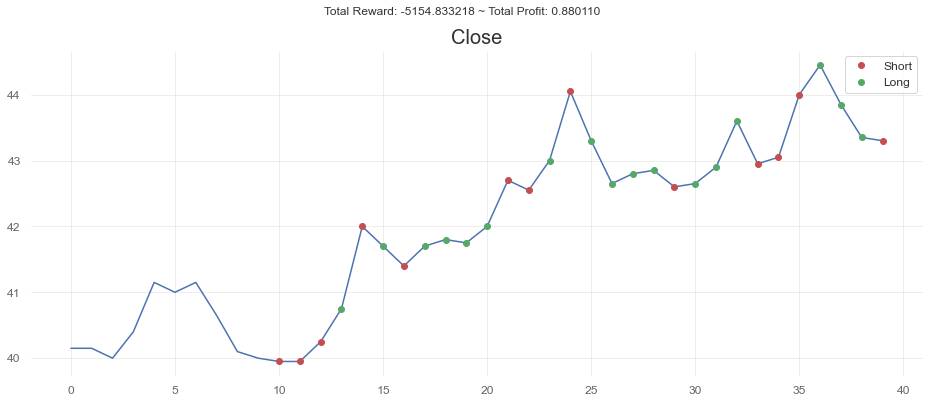

In [17]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓


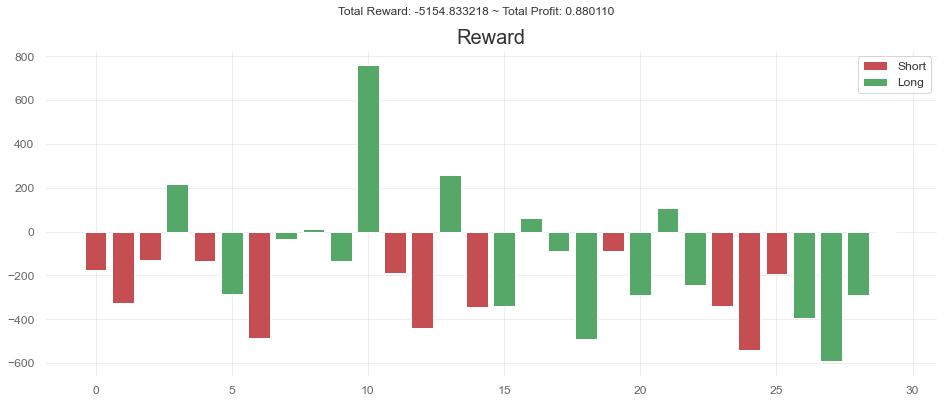

In [18]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


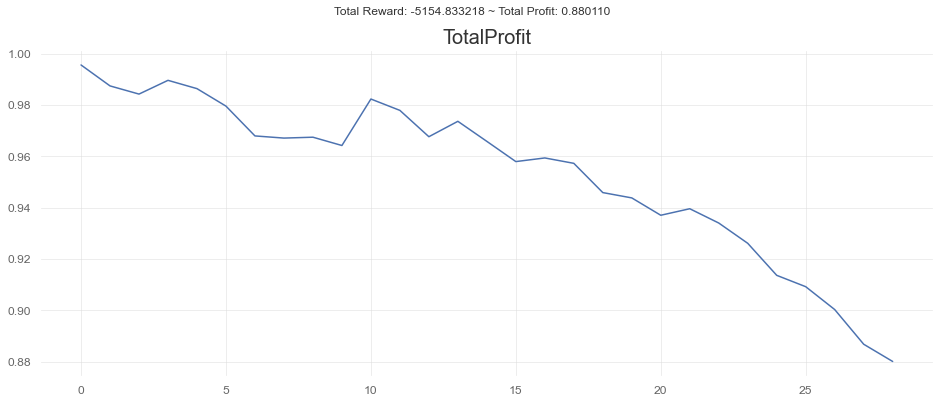

In [19]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [19]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)